In [8]:
#setting for google colab
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

In [5]:
!kill -9 allreg

/bin/sh: 1: kill: Illegal number: all


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [0]:
import random
import numpy as np
from drive.Stanford.CS231n_master.assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [12]:
!sh drive/Stanford/CS231n_master/assignment1/cs231n/datasets/get_datasets.sh

--2018-05-28 03:01:01--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  5.58MB/s    in 26s     

2018-05-28 03:01:28 (6.27 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
from drive.Stanford.CS231n_master.assignment1.cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [0]:
import matplotlib
import numpy as np
from scipy.ndimage import uniform_filter


def extract_features(imgs, feature_fns, verbose=False):
  """
  Given pixel data for images and several feature functions that can operate on
  single images, apply all feature functions to all images, concatenating the
  feature vectors for each image and storing the features for all images in
  a single matrix.

  Inputs:
  - imgs: N x H X W X C array of pixel data for N images.
  - feature_fns: List of k feature functions. The ith feature function should
    take as input an H x W x D array and return a (one-dimensional) array of
    length F_i.
  - verbose: Boolean; if true, print progress.

  Returns:
  An array of shape (N, F_1 + ... + F_k) where each column is the concatenation
  of all features for a single image.
  """
  num_images = imgs.shape[0]
  if num_images == 0:
    return np.array([])

  # Use the first image to determine feature dimensions
  feature_dims = []
  first_image_features = []
  for feature_fn in feature_fns:
    feats = feature_fn(imgs[0].squeeze())
    assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
    feature_dims.append(feats.size)
    first_image_features.append(feats)

  # Now that we know the dimensions of the features, we can allocate a single
  # big array to store all features as columns.
  total_feature_dim = sum(feature_dims)
  imgs_features = np.zeros((num_images, total_feature_dim))
  imgs_features[0] = np.hstack(first_image_features).T

  # Extract features for the rest of the images.
  for i in range(1, num_images):
    idx = 0
    for feature_fn, feature_dim in zip(feature_fns, feature_dims):
      next_idx = idx + feature_dim
      imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
      idx = next_idx
    if verbose and i % 1000 == 0:
      print ('Done extracting features for %d / %d images' % (i, num_images))

  return imgs_features


def rgb2gray(rgb):
  """Convert RGB image to grayscale

    Parameters:
      rgb : RGB image

    Returns:
      gray : grayscale image
  
  """
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])


def hog_feature(im):
  """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
  """
  
  # convert rgb to grayscale if needed
  if im.ndim == 3:
    image = rgb2gray(im)
  else:
    image = np.at_least_2d(im)

  sx, sy = image.shape # image size
  orientations = 9 # number of gradient bins
  cx, cy = (8, 8) # pixels per cell

  gx = np.zeros(image.shape)
  gy = np.zeros(image.shape)
  gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
  gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
  grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

  n_cellsx = int(np.floor(sx / cx))  # number of cells in x
  n_cellsy = int(np.floor(sy / cy))  # number of cells in y
  # compute orientations integral images
  orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
  for i in range(orientations):
    # create new integral image for this orientation
    # isolate orientations in this range
    temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
    temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
    # select magnitudes for those orientations
    cond2 = temp_ori > 0
    temp_mag = np.where(cond2, grad_mag, 0)
    orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[cx//2::cx, cy//2::cy].T
  
  return orientation_histogram.ravel()


def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
  """
  Compute color histogram for an image using hue.

  Inputs:
  - im: H x W x C array of pixel data for an RGB image.
  - nbin: Number of histogram bins. (default: 10)
  - xmin: Minimum pixel value (default: 0)
  - xmax: Maximum pixel value (default: 255)
  - normalized: Whether to normalize the histogram (default: True)

  Returns:
    1D vector of length nbin giving the color histogram over the hue of the
    input image.
  """
  ndim = im.ndim  # 會計算其總共維度
  print("ndim :",ndim)
  bins = np.linspace(xmin, xmax, nbin+1) #創建一個 等差數列的矩陣 從xmin=0  開始 到 xmax=255  共有 nbin+1=11 個
  print("bins :",bins)
  hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax #Colors converted to hsv values in range [0, 1]
  print("hsv :",hsv)
  imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
  print("imhist :",imhist)
  print("bin_edges :",bin_edges)
  imhist = imhist * np.diff(bin_edges)
  print("imhist :",imhist)

  # return histogram
  return imhist


pass

In [22]:
#from drive.Stanford.CS231n_master.assignment1.cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[138.125       16.19047619  63.        ]
  [113.33333333  16.63043478  46.        ]
  [ 30.35714286  35.7         50.        ]
  ...
  [ 20.4         80.69620253 158.        ]
  [ 19.55        83.88157895 152.        ]
  [ 19.83333333  77.53378378 148.        ]]

 [[127.5         51.          20.        ]
  [  0.           0.           0.        ]
  [ 18.88888889 255.          18.        ]
  ...
  [ 20.625      140.97560976 123.        ]
  [ 20.32608696 147.85714286 119.        ]
  [ 19.61538462 135.86065574 122.        ]]

 [[ 31.875       40.8         25.        ]
  [ 18.59375    255.          16.        ]
  [ 19.69512195 213.36734694  49.        ]
  ...
  [ 21.25       146.94915254 118.        ]
  [ 20.64285714 148.75       120.        ]
  [ 19.6641791  156.74311927 109.        ]]

 ...

 [[ 28.08035714 137.30769231 208.        ]
  [ 30.28443114 211.86567164 201.        ]
  [ 33.35755814 221.

[[[ 21.03535354 192.70992366 131.        ]
  [ 21.46907216 199.47580645 124.        ]
  [ 22.13541667 211.03448276 116.        ]
  ...
  [ 23.07142857  97.01086957 184.        ]
  [ 22.5         93.72972973 185.        ]
  [ 21.25        88.69565217 184.        ]]

 [[ 20.825      200.78740157 127.        ]
  [ 21.25       201.53225806 124.        ]
  [ 21.90721649 213.23275862 116.        ]
  ...
  [ 21.54929577 102.28813559 177.        ]
  [ 21.85714286  99.16666667 180.        ]
  [ 21.85714286  95.96774194 186.        ]]

 [[ 21.25       207.31707317 123.        ]
  [ 21.46907216 204.4214876  121.        ]
  [ 22.13541667 216.63716814 113.        ]
  ...
  [ 20.95890411 103.99441341 179.        ]
  [ 20.95890411  99.54545455 187.        ]
  [ 22.36842105  99.89690722 194.        ]]

 ...

 [[ 19.1011236  229.24242424  99.        ]
  [ 20.16025641 239.63855422  83.        ]
  [ 19.08163265 231.38888889  54.        ]
  ...
  [ 21.25       129.34782609 138.        ]
  [ 20.9939759  13


bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.92773438 0.07128906 0.         0.         0.         0.
 0.         0.         0.         0.00097656]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 49.9375     139.7260274   73.        ]
  [ 49.39189189 122.53246753  77.        ]
  [ 39.23076923  75.34090909  88.        ]
  ...
  [ 35.41666667  90.          85.        ]
  [ 33.64583333  71.1627907   86.        ]
  [ 32.3         80.69620253  79.        ]]

 [[ 48.7195122  129.07407407  81.        ]
  [ 47.94871795 118.39285714  84.        ]
  [ 38.10344828  77.84210526  95.        ]
  ...
  [ 33.70689655  87.          85.        ]
  [ 30.6         73.27586207  87.        ]
  [ 31.875       78.46153846  78.        ]]

 [[ 47.68292683 123.          85.        ]
  [ 46.97368421 110.11363636  88.        ]
  [ 36.63793103  76.2371134   97.        ]
  ...
  [ 34.77272727 103.88888889  81.        ]
  [ 3

 [0.70800781 0.00878906 0.00097656 0.01367188 0.0078125  0.05175781
 0.02539062 0.0078125  0.03125    0.14453125]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 36.70454545  52.42990654 107.        ]
  [ 36.42857143  53.28358209  67.        ]
  [ 72.25        77.27272727  33.        ]
  ...
  [ 62.23214286  70.         102.        ]
  [ 37.5         60.20833333  72.        ]
  [ 31.875       55.89041096  73.        ]]

 [[ 13.07692308  30.98130841 107.        ]
  [ 25.5         40.47619048  63.        ]
  [ 77.91666667  46.36363636  33.        ]
  ...
  [ 58.62068966  71.10576923 104.        ]
  [ 51.35416667  71.1627907   86.        ]
  [ 46.75        54.83870968  93.        ]]

 [[ 36.42857143  50.51886792 106.        ]
  [ 25.5         38.05970149  67.        ]
  [ 70.83333333  47.8125      48.        ]
  ...
  [ 53.83333333  79.6875      96.        ]
  [ 54.4         70.05494505  91.        ]
  [ 44.86111111  48.82978723  94.        ]]


bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 28.01136364  99.2920354  113.        ]
  [ 28.01136364 102.         110.        ]
  [ 27.04545455 101.08108108 111.        ]
  ...
  [198.33333333   4.93548387 155.        ]
  [170.           3.07228916 166.        ]
  [170.           2.93103448 174.        ]]

 [[ 26.44444444 100.65789474 114.        ]
  [ 26.68604651  99.68181818 110.        ]
  [ 26.30952381  96.48648649 111.        ]
  ...
  [212.5          4.5        170.        ]
  [184.16666667   4.7515528  161.        ]
  [184.16666667   4.69325153 163.        ]]

 [[ 25.         111.15384615 117.        ]
  [ 24.94565217 101.12068966 116.        ]
  [ 25.5        100.65789474 114.        ]
  ...
  [212.5          6.12       125.        ]
  [198.33333333   6.65217391 115.        ]
  [198.33333333   5.625      136.        ]]

 ...

 [[ 42.5         14.71153846  52.        ]
  [212.5          9.80769231  52.        ]
  [198.33333333  28.86792453

[[[130.15625     22.54143646 181.        ]
  [130.33333333  26.19863014 146.        ]
  [130.76923077  24.375      136.        ]
  ...
  [147.63157895 100.9375      48.        ]
  [147.63157895  71.25        68.        ]
  [147.63157895  82.11864407  59.        ]]

 [[134.21052632  26.62087912 182.        ]
  [130.53571429  31.875      112.        ]
  [127.5         57.24489796  49.        ]
  ...
  [127.5         88.69565217  23.        ]
  [127.5         88.26923077  26.        ]
  [127.5         99.7826087   23.        ]]

 [[139.64285714  37.1875     144.        ]
  [136.60714286  89.25        40.        ]
  [132.22222222 127.5         18.        ]
  ...
  [133.57142857  51.          35.        ]
  [134.58333333  43.71428571  35.        ]
  [134.58333333  61.2         25.        ]]

 ...

 [[ 32.38095238  30.08426966 178.        ]
  [ 31.41304348  43.76865672 134.        ]
  [ 30.10416667  46.71755725 131.        ]
  ...
  [ 31.31578947  25.7712766  188.        ]
  [ 36.42857143  1

 [9.22947304e-03 1.13357843e-02 2.56587010e-03 6.51041667e-04
 5.36151961e-04 9.80392157e-03 4.82536765e-03 1.91482843e-04
 3.82965686e-05 3.82965686e-05]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.23535156 0.2890625  0.06542969 0.01660156 0.01367188 0.25
 0.12304688 0.00488281 0.00097656 0.00097656]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 68.25757576 112.2         75.        ]
  [ 69.74358974 130.85526316  76.        ]
  [ 74.07142857 107.53012048  83.        ]
  ...
  [ 67.61363636  72.85714286  77.        ]
  [ 69.0625      75.55555556  81.        ]
  [ 90.3125      57.46478873  71.        ]]

 [[ 64.26829268 120.17241379  87.        ]
  [ 67.20930233 126.03448276  87.        ]
  [ 71.92307692 124.3125      80.        ]
  ...
  [ 64.53703704  91.8         75.        ]
  [ 68.87931034  89.09638554  83.        ]
  [ 81.30434783  75.19230769  78.        ]]

 [[ 62.78409091 140.25     

imhist : [0.02075674 0.00819547 0.00137868 0.00088082 0.00153186 0.00359988
 0.00084252 0.00011489 0.00026808 0.00164675]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.52929688 0.20898438 0.03515625 0.02246094 0.0390625  0.09179688
 0.02148438 0.00292969 0.00683594 0.04199219]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 21.25        51.81818182 187.        ]
  [ 19.125       55.73770492 183.        ]
  [ 16.19047619  58.20652174 184.        ]
  ...
  [ 18.88888889  64.83050847 177.        ]
  [ 18.88888889  65.19886364 176.        ]
  [ 18.47826087  66.64772727 176.        ]]

 [[ 23.375       54.25531915 188.        ]
  [ 20.23809524  58.20652174 184.        ]
  [ 18.35227273  60.97826087 184.        ]
  ...
  [ 18.88888889  65.57142857 175.        ]
  [ 18.88888889  66.32947977 173.        ]
  [ 18.47826087  67.02857143 175.        ]]

 [[ 24.28571429  57.27272727 187.        ]
  [ 21.25  

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.20507812 0.00097656 0.         0.         0.         0.
 0.03710938 0.171875   0.23632812 0.34863281]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[248.58490566 182.63513514  74.        ]
  [239.82142857  96.48648649  74.        ]
  [224.64285714  44.07407407  81.        ]
  ...
  [251.96428571 146.31147541 122.        ]
  [251.875      144.5        120.        ]
  [250.27777778 151.73553719 121.        ]]

 [[252.22826087 170.          69.        ]
  [198.33333333  20.49107143 112.        ]
  [140.57692308  66.3        150.        ]
  ...
  [251.96428571 145.12195122 123.        ]
  [251.92028986 146.625      120.        ]
  [249.6875     151.73553719 121.        ]]

 [[  2.36111111 145.71428571  63.        ]
  [138.58695652  33.32386364 176.        ]
  [134.39189189  87.76744186 215.        ]
  ...
  [251.4084507  148.40163934 122.        ]
  [251.35714286 1

imhist : [0.06738281 0.015625   0.         0.         0.00097656 0.00585938
 0.79980469 0.08007812 0.01171875 0.01855469]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 21.25        16.06299213 254.        ]
  [ 27.32142857  14.28       250.        ]
  [ 31.875       12.19123506 251.        ]
  ...
  [207.77777778   9.48347107 242.        ]
  [212.5          8.68085106 235.        ]
  [207.77777778   9.93506494 231.        ]]

 [[ 18.21428571  14.         255.        ]
  [ 22.88461538  13.1547619  252.        ]
  [ 30.90909091  11.08695652 253.        ]
  ...
  [216.36363636  11.44897959 245.        ]
  [220.22727273  11.73640167 239.        ]
  [216.36363636  11.93617021 235.        ]]

 [[ 12.75        10.         255.        ]
  [ 17.          10.03937008 254.        ]
  [ 23.61111111   9.         255.        ]
  ...
  [219.58333333  12.38866397 247.        ]
  [219.58333333  12.6446281  242.        ]
  [219.58333333  12.80334728 239.  

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.         0.00195312 0.00390625 0.01171875 0.15917969 0.7890625
 0.03222656 0.00195312 0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 42.5         58.84615385  52.        ]
  [ 42.5         56.66666667  54.        ]
  [ 39.23076923  58.15789474  57.        ]
  ...
  [ 45.33333333  53.125       72.        ]
  [ 45.33333333  52.39726027  73.        ]
  [ 45.33333333  53.125       72.        ]]

 [[ 39.23076923  58.15789474  57.        ]
  [ 38.95833333  51.86440678  59.        ]
  [ 42.5         41.80327869  61.        ]
  ...
  [ 45.          54.87341772  79.        ]
  [ 45.          54.87341772  79.        ]
  [ 45.          54.87341772  79.        ]]

 [[ 33.39285714  66.11111111  54.        ]
  [ 32.69230769  60.27272727  55.        ]
  [ 34.          43.96551724  58.        ]
  ...
  [ 38.02631579  57.67857143  84.        ]
  [ 38.026

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 29.21875     51.         240.        ]
  [ 28.33333333  47.61410788 241.        ]
  [ 27.32142857  43.89344262 244.        ]
  ...
  [ 28.33333333  50.78838174 241.        ]
  [ 28.33333333  50.78838174 241.        ]
  [ 28.33333333  50.78838174 241.        ]]

 [[ 29.21875     50.5785124  242.        ]
  [ 27.38888889  47.22222222 243.        ]
  [ 26.68604651  44.57317073 246.        ]
  ...
  [ 28.62244898  51.41975309 243.        ]
  [ 28.9         52.4691358  243.        ]
  [ 28.33333333  50.5785124  242.        ]]

 [[ 29.48979592  51.41975309 243.        ]
  [ 28.33333333  47.41735537 242.        ]
  [ 27.32142857  43.89344262 244.        ]
  ...
  [ 28.62244898  51.41975309 243.        ]
  [ 28.62244898  51.6322314  242.        ]
  [ 28.62244898  51.6322314  242.        ]]

 ...

 [[ 27.75510204  54.56331878 229.        ]
  [ 24.94565217  49.70338983 236.        ]
  [ 24.41489362  49.11885246 244.   


imhist : [0.00097656 0.         0.         0.         0.         0.77050781
 0.18066406 0.01171875 0.01074219 0.02539062]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 67.64084507 138.20610687 131.        ]
  [ 67.29166667 144.56692913 127.        ]
  [ 67.19594595 152.17741935 124.        ]
  ...
  [187.94444444  49.4612069  232.        ]
  [187.34693878  53.3974359  234.        ]
  [187.          55.19480519 231.        ]]

 [[ 67.87313433 140.04098361 122.        ]
  [ 66.52173913 136.39534884 129.        ]
  [ 65.57142857 146.31147541 122.        ]
  ...
  [187.94444444  49.24892704 233.        ]
  [188.08510638  51.65948276 232.        ]
  [186.47959184  54.32608696 230.        ]]

 [[ 65.9057971  143.04878049 123.        ]
  [ 63.44202899 138.54330709 127.        ]
  [ 61.32142857 139.453125   128.        ]
  ...
  [187.38636364  48.15450644 233.        ]
  [187.94444444  49.4612069  232.        ]
  [188.08510638  52.10869565 230. 


imhist : [0.03417969 0.01269531 0.0078125  0.04003906 0.17675781 0.55664062
 0.09960938 0.0234375  0.00976562 0.0390625 ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 13.6         37.94642857 168.        ]
  [ 12.14285714  36.93103448 145.        ]
  [170.           3.75       136.        ]
  ...
  [ 42.5         37.90540541 222.        ]
  [ 42.5         74.68619247 239.        ]
  [ 45.92281879 157.65560166 241.        ]]

 [[ 14.16666667  42.73743017 179.        ]
  [ 11.59090909  36.42857143 154.        ]
  [159.375        7.03448276 145.        ]
  ...
  [ 40.92592593  30.87443946 223.        ]
  [ 41.89285714  78.28947368 228.        ]
  [ 45.81560284 149.8125     240.        ]]

 [[ 15.34722222  51.86440678 177.        ]
  [ 11.08695652  38.58552632 152.        ]
  [155.83333333   9.6835443  158.        ]
  ...
  [ 42.5         34.51965066 229.        ]
  [ 42.5         88.44594595 222.        ]
  [ 45.04273504 123.7966805  241. 

imhist : [0.00245098 0.00168505 0.00149357 0.00141697 0.00264246 0.0201057
 0.00876991 0.00038297 0.00015319 0.00011489]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.0625     0.04296875 0.03808594 0.03613281 0.06738281 0.51269531
 0.22363281 0.00976562 0.00390625 0.00292969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 42.5          6.         255.        ]
  [ 39.23076923  13.26       250.        ]
  [ 37.4         29.65116279 215.        ]
  ...
  [ 32.16216216  45.14354067 209.        ]
  [ 30.74468085  80.97972973 148.        ]
  [ 31.41304348  84.38848921 139.        ]]

 [[ 56.66666667   6.         255.        ]
  [ 36.42857143   7.11155378 251.        ]
  [ 39.23076923  13.31325301 249.        ]
  ...
  [ 34.23611111  61.2        150.        ]
  [ 31.875       76.84931507 146.        ]
  [ 31.62790698  73.1        150.        ]]

 [[ 48.57142857   7.02755906 254.        ]
  [ 51.     

[0.04296875 0.05078125 0.57519531 0.17480469 0.03710938 0.03027344
 0.03710938 0.02246094 0.00488281 0.02441406]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 53.29365079 243.40909091  66.        ]
  [ 52.8030303  247.5         68.        ]
  [ 53.125      247.71428571  70.        ]
  ...
  [ 48.7962963  233.38983051  59.        ]
  [ 47.5        228.15789474  57.        ]
  [ 45.21276596 226.13207547  53.        ]]

 [[ 53.125      240.          68.        ]
  [ 53.28358209 244.07142857  70.        ]
  [ 52.82142857 247.91666667  72.        ]
  ...
  [ 47.90909091 233.75        60.        ]
  [ 48.11320755 229.06779661  59.        ]
  [ 45.9        227.67857143  56.        ]]

 [[ 53.125      240.          68.        ]
  [ 53.4469697  240.42857143  70.        ]
  [ 52.97101449 244.375       72.        ]
  ...
  [ 48.46491228 234.43548387  62.        ]
  [ 47.90909091 233.75        60.        ]
  [ 46.50943396 229.06779661  59.        ]]


[0.00053615 0.00210631 0.01489737 0.00658701 0.00915288 0.00582108
 0.00011489 0.         0.         0.        ]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.01367188 0.05371094 0.37988281 0.16796875 0.23339844 0.1484375
 0.00292969 0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[221.          10.24096386 249.        ]
  [221.94444444   9.18       250.        ]
  [221.          10.15936255 251.        ]
  ...
  [195.97222222  18.96694215 242.        ]
  [197.5         17.55060729 247.        ]
  [195.5         15.54878049 246.        ]]

 [[198.33333333  12.38866397 247.        ]
  [201.875       12.19123506 251.        ]
  [199.42307692  13.26       250.        ]
  ...
  [200.90909091  11.13095238 252.        ]
  [198.33333333  12.04724409 254.        ]
  [199.75        10.24096386 249.        ]]

 [[188.59375     16.65306122 245.        ]
  [189.83333333  15.4

 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[154.82142857  84.5971564  211.        ]
  [156.31355932  69.65277778 216.        ]
  [156.50793651  74.375      216.        ]
  ...
  [152.66990291 132.65151515 198.        ]
  [152.25728155 132.65151515 198.        ]
  [152.25728155 131.98492462 199.        ]]

 [[157.85714286  21.68016194 247.        ]
  [164.33333333  15.36144578 249.        ]
  [161.9047619   21.76829268 246.        ]
  ...
  [151.59793814 126.84615385 195.        ]
  [151.20192308 133.93939394 198.        ]
  [151.84895833 124.89795918 196.        ]]

 [[161.5         15.23904382 251.        ]
  [159.375       16.58536585 246.        ]
  [157.5         17.83950617 243.        ]
  ...
  [152.44565217 119.69387755 196.        ]
  [152.36702128 118.66336634 202.        ]
  [153.36956522  81.08294931 217.        ]]

 ...

 [[163.92857143  58.52459016 122.        ]
  [161.5         67.69911504 113.        ]
  [161.20689655  70.428571

hsv : [[[ 28.33333333   3.07228916 249.        ]
  [ 42.5         14.875      240.        ]
  [ 46.19565217  24.33609959 241.        ]
  ...
  [ 57.2826087   23.84146341 246.        ]
  [ 61.09375     16.58536585 246.        ]
  [ 99.16666667   3.01181102 254.        ]]

 [[ 52.30769231  14.47598253 229.        ]
  [ 50.37037037  44.13461538 156.        ]
  [ 50.79268293  69.7        150.        ]
  ...
  [ 55.34883721  63.75       172.        ]
  [ 56.16071429  37.38219895 191.        ]
  [ 66.11111111   9.25403226 248.        ]]

 [[ 56.66666667  24.01345291 223.        ]
  [ 52.86585366  81.6796875  128.        ]
  [ 50.56034483 124.28571429 119.        ]
  ...
  [ 53.49137931 121.2295082  122.        ]
  [ 54.48717949  63.34394904 157.        ]
  [ 58.4375      16.58536585 246.        ]]

 ...

 [[ 49.3         28.58744395 223.        ]
  [ 49.03846154  82.19008264 121.        ]
  [ 50.15       115.90909091 110.        ]
  ...
  [  0.           0.           0.        ]
  [ 42.5    

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 53.98648649 129.24657534  73.        ]
  [ 54.64285714 112.97468354  79.        ]
  [ 55.         111.15384615  78.        ]
  ...
  [ 73.98148148 112.86885246  61.        ]
  [ 80.52631579 142.5         34.        ]
  [ 76.9047619  107.1         50.        ]]

 [[ 53.37209302 133.7195122   82.        ]
  [ 53.98648649 134.78571429  70.        ]
  [ 55.37878788 113.71621622  74.        ]
  ...
  [ 70.         104.45783133  83.        ]
  [ 80.52631579 110.11363636  44.        ]
  [ 85.         100.81395349  43.        ]]

 [[ 52.88888889 130.39772727  88.        ]
  [ 54.48717949 144.13043478  69.        ]
  [ 54.453125   113.33333333  72.        ]
  ...
  [ 69.21428571 110.18518519  81.        ]
  [ 80.52631579  88.09090909  55.        ]
  [ 82.5        114.07894737  38.        ]]

 ...

 [[ 59.16666667 100.81395349 129.        ]
  [ 61.38888889  88.26923077 130.        ]
  [ 61.38888889 103.

imhist : [9.22947304e-03 1.57398897e-02 7.50612745e-03 2.25949755e-03
 2.33609069e-03 9.19117647e-04 1.11060049e-03 3.82965686e-05
 0.00000000e+00 7.65931373e-05]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.23535156 0.40136719 0.19140625 0.05761719 0.05957031 0.0234375
 0.02832031 0.00097656 0.         0.00195312]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  8.5         19.921875    64.        ]
  [  8.5         21.61016949  59.        ]
  [  8.5         20.23809524  63.        ]
  ...
  [233.75        27.56756757  37.        ]
  [240.83333333  23.18181818  33.        ]
  [240.83333333  21.85714286  35.        ]]

 [[  8.5         17.22972973  74.        ]
  [  8.5         18.21428571  70.        ]
  [  8.5         18.47826087  69.        ]
  ...
  [240.83333333  25.93220339  59.        ]
  [242.85714286  41.51162791  43.        ]
  [233.75        40.26315789  38.        ]]

 [[  8.5      

hsv : [[[  6.57738095 125.26315789 171.        ]
  [ 15.25641026  64.57792208 154.        ]
  [ 72.25        22.46696035 227.        ]
  ...
  [133.24324324  41.74778761 226.        ]
  [135.54054054  41.20087336 229.        ]
  [134.75609756  47.52272727 220.        ]]

 [[  5.93023256 128.24561404 171.        ]
  [ 19.01315789 129.2         75.        ]
  [ 91.25        55.57692308 156.        ]
  ...
  [132.65151515  36.27155172 232.        ]
  [134.78571429  38.30472103 233.        ]
  [134.03846154  44.59641256 223.        ]]

 [[  6.13888889 126.79558011 181.        ]
  [ 20.1875     118.60465116  86.        ]
  [ 95.38888889 168.75        68.        ]
  ...
  [132.98387097  33.92703863 233.        ]
  [132.98387097  34.22077922 231.        ]
  [133.40277778  39.91304348 230.        ]]

 ...

 [[  6.375       96.22641509  53.        ]
  [ 14.16666667  22.17391304 138.        ]
  [ 25.          26.59509202 163.        ]
  ...
  [ 48.875       32.69230769 156.        ]
  [ 49.58333

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[127.95698925 170.61151079 139.        ]
  [128.44444444 155.06756757 148.        ]
  [128.93258427 146.41935484 155.        ]
  ...
  [129.5        145.46979866 149.        ]
  [129.43181818 153.69863014 146.        ]
  [127.96195652 173.77777778 135.        ]]

 [[126.98795181 144.96575342 146.        ]
  [129.2         96.59090909 198.        ]
  [130.57971014  81.08294931 217.        ]
  ...
  [134.27536232  84.18660287 209.        ]
  [132.53289474 100.41450777 193.        ]
  [129.52380952 149.79020979 143.        ]]

 [[126.98795181 135.67307692 156.        ]
  [129.46153846  73.01762115 227.        ]
  [132.40384615  52.41106719 253.        ]
  ...
  [137.75862069  59.63709677 248.        ]
  [132.5         78.46153846 221.        ]
  [128.53658537 141.28378378 148.        ]]

 ...

 [[126.56593407 160.03448276 145.        ]
  [127.5        104.05172414 174.        ]
  [129.73684211  78.14516129 186.  

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.02441406 0.03320312 0.13378906 0.06738281 0.04785156 0.62792969
 0.03808594 0.00488281 0.00976562 0.01269531]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[101.52777778  27.48502994 167.        ]
  [102.5         25.65088757 169.        ]
  [102.5         24.77142857 175.        ]
  ...
  [105.13157895  26.18918919 185.        ]
  [101.52777778  26.84210526 171.        ]
  [102.89473684  27.37288136 177.        ]]

 [[104.31818182  32.42774566 173.        ]
  [104.31818182  34.20731707 164.        ]
  [104.31818182  31.51685393 178.        ]
  ...
  [105.4         34.09090909 187.        ]
  [106.25        39.23076923 156.        ]
  [105.4         39.59627329 161.        ]]

 [[ 93.5         17.11409396 149.        ]
  [ 93.5         18.34532374 139.        ]
  [ 96.59090909  18.09677419 155.        ]
  ...
  [104.47916667  35.17241379 174.        ]
  [104.479

 [0.         0.         0.         0.         0.         0.01681219
 0.01685049 0.00436581 0.00118719 0.        ]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.         0.         0.         0.         0.         0.42871094
 0.4296875  0.11132812 0.03027344 0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[110.5         16.66666667 153.        ]
  [127.5          1.13333333 225.        ]
  [  0.           0.         255.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[113.33333333  22.5        170.        ]
  [116.875        5.36842105 190.        ]
  [226.66666667   3.         255.        ]
  ...
  [ 14.16666667   3.         255.        ]
  [212.5          1.00393701 254.        ]
  [191.25         2.         255.        ]]

 [[112.32142857  19.50819672 183.        ]
  [116.875       12

[[[ 36.42857143  33.46875    160.        ]
  [ 36.42857143  40.56818182 132.        ]
  [ 36.42857143  47.8125     112.        ]
  ...
  [ 85.          15.37688442 199.        ]
  [ 76.5         12.87878788 198.        ]
  [ 72.25        12.81407035 199.        ]]

 [[ 38.02631579  52.66304348  92.        ]
  [ 38.25        65.38461538  78.        ]
  [ 38.02631579  64.6         75.        ]
  ...
  [ 98.52272727  26.97115385 208.        ]
  [100.45454545  26.33802817 213.        ]
  [ 97.75        24.05660377 212.        ]]

 [[ 45.          57.03947368  76.        ]
  [ 42.5         55.13513514  74.        ]
  [ 42.5         59.38356164  73.        ]
  ...
  [ 92.96875     20.09852217 203.        ]
  [ 92.5         21.25       204.        ]
  [ 87.65625     21.13989637 193.        ]]

 ...

 [[ 99.16666667  28.86792453  53.        ]
  [ 99.16666667  25.93220339  59.        ]
  [ 99.16666667  14.71153846 104.        ]
  ...
  [ 95.625        5.20408163 196.        ]
  [ 99.16666667   

hsv : [[[ 99.16666667  43.96551724  87.        ]
  [123.95833333  38.25        80.        ]
  [114.75        27.7173913   92.        ]
  ...
  [ 45.53571429  33.67924528 106.        ]
  [ 36.70454545  49.6460177  113.        ]
  [ 42.5         16.68224299 107.        ]]

 [[102.          21.42857143 119.        ]
  [115.90909091  28.33333333  99.        ]
  [ 95.625       33.26086957  92.        ]
  ...
  [ 74.375       20.         102.        ]
  [ 42.5         20.86363636 110.        ]
  [ 42.5         22.76785714 112.        ]]

 [[ 97.14285714  13.52272727 132.        ]
  [ 75.19230769  30.41284404 109.        ]
  [ 71.92307692  32.18446602 103.        ]
  ...
  [118.05555556  25.5         90.        ]
  [ 39.84375     37.43119266 109.        ]
  [ 45.15625     42.5         96.        ]]

 ...

 [[111.5625      27.2         75.        ]
  [ 85.           9.80769231  78.        ]
  [ 59.5         14.01098901  91.        ]
  ...
  [ 49.58333333  30.         102.        ]
  [ 48.57142

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[109.28571429   9.70108696 184.        ]
  [ 63.75        10.26845638 149.        ]
  [ 54.64285714  12.39583333 144.        ]
  ...
  [ 94.65909091  42.18045113 133.        ]
  [ 64.12280702  95.         153.        ]
  [ 63.4939759  107.98469388 196.        ]]

 [[133.57142857   9.86187845 181.        ]
  [ 48.57142857  11.9        150.        ]
  [ 38.63636364  20.32608696 138.        ]
  ...
  [ 65.38461538  96.92982456 171.        ]
  [ 66.11111111  94.63917526 194.        ]
  [ 67.61363636  92.98342541 181.        ]]

 [[127.5          8.70731707 205.        ]
  [ 47.22222222  16.39285714 140.        ]
  [ 29.07894737  43.64864865 111.        ]
  ...
  [ 63.75       101.49253731 201.        ]
  [ 70.0877193   81.20111732 179.        ]
  [ 72.06521739  74.24050633 158.        ]]

 ...

 [[ 42.5         25.5        120.        ]
  [ 31.31578947  37.26923077 130.        ]
  [ 34.          53.

[[[106.25        17.5862069   29.        ]
  [ 70.83333333  27.32142857  28.        ]
  [ 56.66666667  41.35135135  37.        ]
  ...
  [ 55.25        87.93103448  58.        ]
  [ 60.0862069   94.80769231  78.        ]
  [ 59.5        130.39772727  88.        ]]

 [[ 70.83333333  20.67567568  37.        ]
  [ 63.75        45.          34.        ]
  [ 54.64285714  36.42857143  49.        ]
  ...
  [ 57.95454545  93.5         60.        ]
  [ 57.67857143  97.80821918  73.        ]
  [ 55.13513514 112.32142857  84.        ]]

 [[ 68.          30.35714286  42.        ]
  [ 60.71428571  44.625       40.        ]
  [ 56.66666667  34.25373134  67.        ]
  ...
  [ 57.95454545  93.5         60.        ]
  [ 57.21153846  90.82191781  73.        ]
  [ 51.51515152 129.46153846  65.        ]]

 ...

 [[ 60.71428571 121.31067961 103.        ]
  [ 62.06349206 148.75       108.        ]
  [ 62.07236842 155.04       125.        ]
  ...
  [ 60.12195122 154.88888889 135.        ]
  [ 61.81818182 17


imhist : [0.81738281 0.109375   0.00488281 0.00683594 0.00390625 0.046875
 0.00097656 0.         0.00585938 0.00390625]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 63.75         4.85714286 105.        ]
  [  0.           5.93023256  86.        ]
  [  6.07142857  76.93965517 116.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[ 53.125       16.72131148  61.        ]
  [ 14.16666667  23.90625     32.        ]
  [  4.16666667 166.73076923  78.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[ 59.5         24.05660377  53.        ]
  [ 25.5         91.07142857  28.        ]
  [  5.40909091 182.14285714  77.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.   


imhist : [0.03027344 0.046875   0.22167969 0.04785156 0.01855469 0.17480469
 0.1953125  0.05664062 0.06640625 0.14160156]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]
  ...
  [  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]]

 [[  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 254.]
  ...
  [  0.   0. 254.]
  [  0.   0. 254.]
  [  0.   0. 254.]]

 [[  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]
  ...
  [  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]]

 ...

 [[  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 253.]
  ...
  [  0.   0. 167.]
  [  0.   0. 225.]
  [  0.   0. 252.]]

 [[  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 252.]
  ...
  [  0.   0. 187.]
  [  0.   0. 226.]
  [  0.   0. 251.]]

 [[  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]
  ...
  [  0.   0. 243.]
  [  0.   0. 248.]
  [  0.   0. 253.]]]
imhist : [0.03921569 0.         0.         0.    

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.06640625 0.76953125 0.15917969 0.         0.         0.
 0.00097656 0.00097656 0.         0.00292969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 14.65517241 157.34042553  94.        ]
  [ 19.89361702 149.8125      80.        ]
  [ 20.77777778 138.25301205  83.        ]
  ...
  [ 24.79166667  26.15384615 117.        ]
  [ 42.5          1.7114094  149.        ]
  [148.75         9.80769231 156.        ]]

 [[ 21.79487179 134.39189189  74.        ]
  [ 18.88888889 114.75        80.        ]
  [ 20.1875     120.          85.        ]
  ...
  [ 23.90625     32.38095238 126.        ]
  [ 23.90625     28.33333333 144.        ]
  [ 11.59090909  19.61538462 143.        ]]

 [[ 19.69512195 127.5         82.        ]
  [ 21.79487179 121.2804878   82.        ]
  [ 19.31818182 107.88461538  78.        ]
  ...
  [ 21.25        52.75862069 116.        ]
  [ 25.5         2


hsv : [[[156.21621622  39.14937759 241.        ]
  [157.85714286  37.1875     240.        ]
  [160.          35.67901235 243.        ]
  ...
  [155.42857143  37.9787234  235.        ]
  [153.91891892  40.14893617 235.        ]
  [154.45121951  44.67948718 234.        ]]

 [[153.57954545  47.34177215 237.        ]
  [154.82142857  45.57446809 235.        ]
  [156.52439024  43.92857143 238.        ]
  ...
  [154.21428571  37.34309623 239.        ]
  [154.34210526  40.375      240.        ]
  [155.125       42.85714286 238.        ]]

 [[151.40625     52.08510638 235.        ]
  [153.94444444  49.4612069  232.        ]
  [155.51136364  48.15450644 233.        ]
  ...
  [155.42857143  37.5        238.        ]
  [154.34210526  40.54393305 239.        ]
  [154.45121951  43.92857143 238.        ]]

 ...

 [[ 34.77272727  24.60526316 114.        ]
  [ 34.77272727  28.05       100.        ]
  [ 35.41666667  29.42307692 104.        ]
  ...
  [  0.          20.30973451 113.        ]
  [250.2777

 [0.00878906 0.02246094 0.00488281 0.00488281 0.01855469 0.90722656
 0.0234375  0.00195312 0.00292969 0.00488281]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[150.71759259 150.49180328 183.        ]
  [150.75471698 147.70491803 183.        ]
  [150.53738318 146.69354839 186.        ]
  ...
  [150.83333333 132.70408163 196.        ]
  [150.64356436 132.75773196 194.        ]
  [150.64356436 134.140625   192.        ]]

 [[150.53738318 145.13297872 188.        ]
  [150.35377358 143.01587302 189.        ]
  [150.35377358 140.78125    192.        ]
  ...
  [150.68181818 126.225      200.        ]
  [150.25252525 127.5        198.        ]
  [150.25252525 128.80102041 196.        ]]

 [[149.15865385 139.57894737 190.        ]
  [149.36893204 137.51308901 191.        ]
  [149.36893204 135.38659794 194.        ]
  ...
  [149.65425532 119.25373134 201.        ]
  [150.10638298 119.85       200.        ]
  [150.10638298 121.06060606 198.        ]]

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[116.875       56.66666667  18.        ]
  [113.33333333  45.          17.        ]
  [116.875       53.68421053  19.        ]
  ...
  [116.875       63.75        16.        ]
  [116.875       78.46153846  13.        ]
  [116.875       63.75        16.        ]]

 [[116.875       53.68421053  19.        ]
  [116.875       53.68421053  19.        ]
  [116.875       53.68421053  19.        ]
  ...
  [116.875       68.          15.        ]
  [116.875       78.46153846  13.        ]
  [116.875       56.66666667  18.        ]]

 [[116.875       51.          20.        ]
  [116.875       53.68421053  19.        ]
  [116.875       53.68421053  19.        ]
  ...
  [116.875       63.75        16.        ]
  [116.875       78.46153846  13.        ]
  [116.875       60.          17.        ]]

 ...

 [[178.5         35.41666667  36.        ]
  [178.5         34.45945946  37.        ]
  [178.5         31.

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.06445312 0.09765625 0.39648438 0.06542969 0.03417969 0.26074219
 0.06054687 0.00292969 0.00195312 0.015625  ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[141.35869565  90.93023256 129.        ]
  [140.15957447  86.84782609 138.        ]
  [136.21794872  69.54545455 143.        ]
  ...
  [142.95454545 105.45112782 133.        ]
  [142.21153846 102.         130.        ]
  [141.39423077 102.79069767 129.        ]]

 [[142.5        103.21428571 126.        ]
  [141.06382979  92.90697674 129.        ]
  [136.25        71.65289256 121.        ]
  ...
  [142.5        102.4015748  127.        ]
  [141.02272727  98.42105263 114.        ]
  [140.34883721  96.18421053 114.        ]]

 [[142.8        104.50819672 122.        ]
  [142.2826087   98.57142857 119.        ]
  [140.37878788  89.5212766   94.        ]
  ...
  [141.02272727  92.72727273 121.        ]
  [140.37

 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[150.68181818  41.04878049 205.        ]
  [151.11111111  33.26086957 207.        ]
  [152.29166667  28.59813084 214.        ]
  ...
  [166.13636364  12.86697248 218.        ]
  [173.86363636  12.92626728 217.        ]
  [181.59090909  12.92626728 217.        ]]

 [[154.54545455  26.21495327 214.        ]
  [153.47222222  21.44859813 214.        ]
  [151.40625     18.46153846 221.        ]
  ...
  [158.66666667  17.62672811 217.        ]
  [163.46153846  15.34722222 216.        ]
  [170.          12.98611111 216.        ]]

 [[158.19444444  20.22026432 227.        ]
  [152.5         19.61538462 221.        ]
  [146.09375     18.63013699 219.        ]
  ...
  [150.875       24.17061611 211.        ]
  [153.47222222  21.34883721 215.        ]
  [160.          19.79452055 219.        ]]

 ...

 [[157.40740741  63.16513761 109.        ]
  [157.40740741  66.84466019 103.        ]
  [157.40740741  68.168316

hsv : [[[ 27.48641304 204.         230.        ]
  [ 24.65469613 192.3125     240.        ]
  [ 25.60897436 181.64383562 219.        ]
  ...
  [ 26.5625     202.31404959 242.        ]
  [ 25.94736842 202.71966527 239.        ]
  [ 25.90909091 198.6875     240.        ]]

 [[ 25.54913295 182.29338843 242.        ]
  [ 23.47383721 185.84745763 236.        ]
  [ 24.69594595 194.53608247 194.        ]
  ...
  [ 26.53439153 196.71428571 245.        ]
  [ 25.68181818 192.27822581 248.        ]
  [ 25.68181818 192.27822581 248.        ]]

 [[ 25.07022472 194.80686695 233.        ]
  [ 23.52678571 188.72246696 227.        ]
  [ 23.2962963  185.08064516 186.        ]
  ...
  [ 25.04054054 190.99190283 247.        ]
  [ 24.25271739 189.95951417 247.        ]
  [ 24.22043011 195.18518519 243.        ]]

 ...

 [[ 20.50872093 193.21585903 227.        ]
  [ 19.22619048 195.61643836 219.        ]
  [ 18.86094675 196.78082192 219.        ]
  ...
  [ 18.54545455 150.80645161  93.        ]
  [ 24.02173

hsv : [[[ 65.80645161  87.83333333  90.        ]
  [ 63.75        85.          72.        ]
  [ 57.375       45.13274336 113.        ]
  ...
  [ 73.1         99.609375    64.        ]
  [ 73.1         92.39130435  69.        ]
  [ 73.1        120.28301887  53.        ]]

 [[ 68.91891892 109.70930233  86.        ]
  [ 67.29166667  83.83561644  73.        ]
  [ 51.60714286  23.8        150.        ]
  ...
  [ 67.68518519 135.          51.        ]
  [ 68.65384615 120.54545455  55.        ]
  [ 68.65384615 122.77777778  54.        ]]

 [[ 69.54545455 101.38554217  83.        ]
  [ 64.76190476  54.09090909  99.        ]
  [ 38.95833333  15.53299492 197.        ]
  ...
  [ 66.52173913 102.89473684  57.        ]
  [ 67.61363636 136.82926829  41.        ]
  [ 67.61363636 130.46511628  43.        ]]

 ...

 [[ 22.66666667  43.22033898 177.        ]
  [ 27.84482759  44.54819277 166.        ]
  [ 34.91071429  49.58333333 144.        ]
  ...
  [ 42.5         31.64233577 137.        ]
  [ 46.75   

[0.23730469 0.39453125 0.03320312 0.01269531 0.00585938 0.04492188
 0.0546875  0.03515625 0.11230469 0.06933594]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[142.03225806 159.375      248.        ]
  [140.94632768 181.99596774 248.        ]
  [141.34285714 177.78884462 251.        ]
  ...
  [135.42910448 137.78225806 248.        ]
  [136.30357143 143.9516129  248.        ]
  [137.10616438 149.51807229 249.        ]]

 [[142.02531646 160.51792829 251.        ]
  [141.03351955 181.85258964 251.        ]
  [141.34831461 178.         255.        ]
  ...
  [135.56569343 137.53937008 254.        ]
  [136.17957746 142.         255.        ]
  [137.13333333 150.         255.        ]]

 [[141.75806452 159.375      248.        ]
  [140.87078652 183.02419355 248.        ]
  [141.26420455 178.0952381  252.        ]
  ...
  [135.81521739 139.09090909 253.        ]
  [136.11888112 143.56299213 254.        ]
  [137.13333333 151.18577075 253.        ]]


imhist : [3.44669118e-04 1.53186275e-04 1.43229167e-02 6.31893382e-03
 5.39981618e-03 1.14123775e-02 9.95710784e-04 1.53186275e-04
 7.65931373e-05 3.82965686e-05]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.00878906 0.00390625 0.36523438 0.16113281 0.13769531 0.29101562
 0.02539062 0.00390625 0.00195312 0.00097656]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 60.44444444  51.68918919 222.        ]
  [ 60.81896552  68.15668203 217.        ]
  [ 60.97826087  79.61538462 221.        ]
  ...
  [ 71.4         28.71621622 222.        ]
  [ 72.85714286  33.20930233 215.        ]
  [ 74.6969697   40.84951456 206.        ]]

 [[ 66.11111111  41.53846154 221.        ]
  [ 64.22222222  51.92307692 221.        ]
  [ 63.33333333  58.05803571 224.        ]
  ...
  [ 79.6875      28.46511628 215.        ]
  [ 81.6         29.65116279 215.        ]
  [ 80.27777778  33.10096154 208.        ]]

 [[ 70.833333

[0.05371094 0.10839844 0.01269531 0.01855469 0.03320312 0.30175781
 0.40332031 0.04199219 0.01367188 0.01269531]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 85.          13.16129032 155.        ]
  [ 75.55555556  14.71153846 156.        ]
  [ 57.95454545  17.98076923 156.        ]
  ...
  [ 22.72277228 112.46724891 229.        ]
  [ 19.83333333 111.5625     240.        ]
  [ 19.18141593 117.13414634 246.        ]]

 [[ 85.          11.59090909 154.        ]
  [ 75.55555556  15.09868421 152.        ]
  [ 57.95454545  18.45394737 152.        ]
  ...
  [ 26.5625      75.55555556 189.        ]
  [ 23.82575758  85.86734694 196.        ]
  [ 23.27380952 100.56338028 213.        ]]

 [[ 85.          11.59090909 154.        ]
  [ 75.55555556  14.61783439 157.        ]
  [ 57.95454545  17.86624204 157.        ]
  ...
  [ 24.79166667  47.07692308 195.        ]
  [ 24.87804878  54.17098446 193.        ]
  [ 25.67708333  64.08376963 191.        ]]


[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[158.81578947  19.30278884 251.        ]
  [164.6875       8.71794872 234.        ]
  [240.83333333   3.4        225.        ]
  ...
  [174.72222222  12.54098361 183.        ]
  [174.72222222  11.64974619 197.        ]
  [180.625        9.90291262 206.        ]]

 [[164.9         25.39840637 251.        ]
  [170.          13.0212766  235.        ]
  [226.66666667   3.37004405 227.        ]
  ...
  [ 14.16666667  13.30434783 230.        ]
  [ 14.16666667  12.96610169 236.        ]
  [ 15.17857143  14.75206612 242.        ]]

 [[165.27777778  27.10629921 254.        ]
  [172.5         17.91322314 242.        ]
  [185.9375       8.90829694 229.        ]
  ...
  [ 18.88888889  18.73469388 245.        ]
  [ 18.88888889  18.73469388 245.        ]
  [ 19.125       20.98765432 243.        ]]

 ...

 [[ 15.17857143  31.45374449 227.        ]
  [ 13.07692308  30.         221.        ]
  [ 10.2         28.08370044 227.   

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.625       93.57798165 109.        ]
  [151.78571429  93.94736842 114.        ]
  [155.1744186  115.42105263  95.        ]
  ...
  [121.42857143  34.32692308 104.        ]
  [113.33333333  33.55263158 114.        ]
  [106.25        20.56451613 124.        ]]

 [[150.52083333  51.42857143 119.        ]
  [153.          67.69911504 113.        ]
  [154.54545455  90.48387097  93.        ]
  ...
  [233.75         5.15151515  99.        ]
  [ 14.16666667  14.57142857 105.        ]
  [ 24.28571429  29.26229508 122.        ]]

 [[143.4375      34.87179487 117.        ]
  [143.4375      58.28571429 105.        ]
  [146.55172414  80.38043478  92.        ]
  ...
  [ 18.59375     34.28571429 119.        ]
  [ 15.65789474  37.55813953 129.        ]
  [ 15.65789474  35.3649635  137.        ]]

 ...

 [[ 53.58695652  54.81308411 107.        ]
  [ 51.35416667  53.2173913  115.        ]
  [ 45.9         54.

[0.11035156 0.18652344 0.03125    0.01855469 0.06542969 0.46972656
 0.06445312 0.02539062 0.00976562 0.01855469]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.38888889  18.65853659 246.        ]
  [146.38888889  18.73469388 245.        ]
  [146.38888889  18.65853659 246.        ]
  ...
  [150.16666667  15.05905512 254.        ]
  [145.71428571  14.         255.        ]
  [145.20833333  12.         255.        ]]

 [[145.71428571  22.3125     240.        ]
  [146.625       21.42857143 238.        ]
  [144.5         21.33891213 239.        ]
  ...
  [150.16666667  15.17857143 252.        ]
  [150.16666667  15.11857708 253.        ]
  [150.16666667  15.05905512 254.        ]]

 [[145.20833333  25.60669456 239.        ]
  [146.2         26.78571429 238.        ]
  [145.97826087  24.64285714 238.        ]
  ...
  [151.78571429  14.16666667 252.        ]
  [150.16666667  15.11857708 253.        ]
  [150.16666667  15.05905512 254.        ]]



ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 35.41666667 100.32786885 244.        ]
  [ 34.5049505  103.02       250.        ]
  [ 33.19047619 107.53012048 249.        ]
  ...
  [ 22.71551724 162.52747253  91.        ]
  [ 24.67741935 159.6969697   99.        ]
  [ 26.15384615 153.47222222 108.        ]]

 [[ 36.55913978  96.01214575 247.        ]
  [ 35.92783505  97.         255.        ]
  [ 35.2020202   99.38976378 254.        ]
  ...
  [ 23.61111111 158.27586207  87.        ]
  [ 24.72727273 154.12087912  91.        ]
  [ 25.04464286 150.31578947  95.        ]]

 [[ 37.77777778  92.1686747  249.        ]
  [ 37.41847826  92.72727273 253.        ]
  [ 37.01612903  94.10714286 252.        ]
  ...
  [ 24.14772727 149.6         75.        ]
  [ 23.61111111 155.06756757  74.        ]
  [ 23.18181818 158.02816901  71.        ]]

 ...

 [[ 41.171875    64.76190476 252.        ]
  [ 41.84615385  65.         255.        ]
  [ 41.86567164  67

 [1.66973039e-02 1.99142157e-02 1.60845588e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.65931373e-05 3.82965686e-05
 3.82965686e-05 8.42524510e-04]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.42578125 0.5078125  0.04101562 0.         0.         0.
 0.00195312 0.00097656 0.00097656 0.02148438]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[  0.           0.         255.        ]
  [141.66666667   3.01181102 254.        ]
  [170.           2.02380952 252.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         254.        ]
  [  0.           0.         255.        ]]

 [[  0.           0.         

hsv : [[[152.12616822 146.69354839 186.        ]
  [151.95754717 146.10810811 185.        ]
  [151.50462963 147.27272727 187.        ]
  ...
  [151.25       139.09090909 187.        ]
  [151.25       138.35106383 188.        ]
  [151.3        136.36363636 187.        ]]

 [[151.62162162 149.76190476 189.        ]
  [151.84090909 149.20212766 188.        ]
  [151.78571429 150.31578947 190.        ]
  ...
  [151.01941748 137.51308901 191.        ]
  [151.43203883 136.796875   192.        ]
  [151.84466019 137.51308901 191.        ]]

 [[151.78571429 151.91489362 188.        ]
  [151.62162162 151.36363636 187.        ]
  [151.78571429 151.11111111 189.        ]
  ...
  [151.66666667 137.61904762 189.        ]
  [151.43203883 138.96825397 189.        ]
  [151.66666667 138.35106383 188.        ]]

 ...

 [[152.38738739 147.421875   192.        ]
  [152.0045045  148.19371728 191.        ]
  [151.78571429 148.75       192.        ]
  ...
  [151.01941748 136.0880829  193.        ]
  [150.79326

[[[ 42.5         35.78947368  57.        ]
  [ 39.46428571  58.52459016  61.        ]
  [ 53.125       38.49056604  53.        ]
  ...
  [ 57.5         66.69230769  65.        ]
  [ 56.66666667  71.71875     64.        ]
  [ 59.5         61.69354839  62.        ]]

 [[ 51.60714286  56.66666667  63.        ]
  [ 44.86111111  66.52173913  69.        ]
  [ 49.03846154  53.46774194  62.        ]
  ...
  [ 57.8         83.88157895  76.        ]
  [ 58.24074074  94.31506849  73.        ]
  [ 59.88636364  83.73134328  67.        ]]

 [[ 53.68421053  76.9047619   63.        ]
  [ 46.54761905  76.5         70.        ]
  [ 52.5         61.92857143  70.        ]
  ...
  [ 48.7962963   87.15189873  79.        ]
  [ 48.57142857  97.80821918  73.        ]
  [ 49.58333333  92.72727273  66.        ]]

 ...

 [[ 26.89873418 191.85714286 105.        ]
  [ 29.46022727 196.84210526 114.        ]
  [ 32.27848101 181.48648649 111.        ]
  ...
  [ 32.16216216 161.28205128 117.        ]
  [ 31.74698795 16

 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[140.81325301 143.00675676 148.        ]
  [140.81325301 143.97959184 147.        ]
  [141.3253012  143.97959184 147.        ]
  ...
  [138.27464789 116.05769231 156.        ]
  [138.42857143 114.42307692 156.        ]
  [138.56164384 117.0754717  159.        ]]

 [[139.5        143.54304636 151.        ]
  [140.14880952 142.8        150.        ]
  [140.         144.5        150.        ]
  ...
  [138.53896104 120.4601227  163.        ]
  [138.68421053 118.89570552 163.        ]
  [138.53896104 119.         165.        ]]

 [[138.63095238 143.75838926 149.        ]
  [138.63095238 144.72972973 148.        ]
  [139.13690476 144.72972973 148.        ]
  ...
  [138.65625    122.89156627 166.        ]
  [138.65625    122.15568862 167.        ]
  [138.65625    120.71005917 169.        ]]

 ...

 [[ 85.          18.88888889 189.        ]
  [ 75.          20.44811321 212.        ]
  [ 69.34210526  21.157205

[[[ 38.95833333  93.86503067 163.        ]
  [ 38.89830508 103.04794521 146.        ]
  [ 38.89830508 103.04794521 146.        ]
  ...
  [ 32.64492754 124.78723404 141.        ]
  [ 33.26086957 123.04195804 143.        ]
  [ 35.52238806 120.31690141 142.        ]]

 [[ 39.01639344  95.42944785 163.        ]
  [ 38.95833333 104.79452055 146.        ]
  [ 38.95833333 100.65789474 152.        ]
  ...
  [ 32.32394366 124.00684932 146.        ]
  [ 33.39285714 126.59574468 141.        ]
  [ 35.         122.11267606 142.        ]]

 [[ 39.01639344  96.01851852 162.        ]
  [ 38.95833333 106.25       144.        ]
  [ 38.95833333  96.83544304 158.        ]
  ...
  [ 32.78571429 120.60810811 148.        ]
  [ 33.87681159 123.04195804 143.        ]
  [ 35.52238806 120.31690141 142.        ]]

 ...

 [[ 38.02631579  88.62804878 164.        ]
  [ 37.94642857  79.77653631 179.        ]
  [ 38.63636364  75.         187.        ]
  ...
  [ 34.91071429  85.         168.        ]
  [ 36.2037037   7

[[[212.5         41.28571429 105.        ]
  [212.5         45.15625     96.        ]
  [212.5         40.13888889 108.        ]
  ...
  [ 29.14285714  75.         119.        ]
  [ 35.7         54.48717949 117.        ]
  [ 38.25        42.5        120.        ]]

 [[223.68421053  44.86111111 108.        ]
  [221.94444444  44.5631068  103.        ]
  [221.94444444  46.36363636  99.        ]
  ...
  [ 15.9375      57.87234043 141.        ]
  [ 23.18181818  33.39285714 168.        ]
  [ 36.42857143  19.19354839 186.        ]]

 [[231.81818182  52.42990654 107.        ]
  [232.73809524  50.04672897 107.        ]
  [230.71428571  52.5        102.        ]
  ...
  [  5.54347826  29.17910448 201.        ]
  [ 12.14285714  17.67326733 202.        ]
  [ 30.90909091  17.10365854 164.        ]]

 ...

 [[ 29.42307692  31.57142857 105.        ]
  [ 23.61111111  24.67741935  93.        ]
  [  0.          14.65517241  87.        ]
  ...
  [240.83333333  14.29906542 107.        ]
  [236.78571429  1

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[144.5         54.95689655 116.        ]
  [144.765625    73.51351351 111.        ]
  [143.24074074  68.85       100.        ]
  ...
  [146.55172414  68.47222222 108.        ]
  [145.32258065  75.28571429 105.        ]
  [141.66666667  48.68181818 110.        ]]

 [[139.83870968  65.875      120.        ]
  [140.92105263  76.2992126  127.        ]
  [140.          76.05263158 114.        ]
  ...
  [145.12195122  99.57142857 105.        ]
  [144.70238095 103.98058252 103.        ]
  [143.62068966  69.76415094 106.        ]]

 [[138.125       78.46153846 117.        ]
  [139.64285714  85.68       125.        ]
  [139.48717949  81.51639344 122.        ]
  ...
  [143.55555556 111.40776699 103.        ]
  [144.5        113.61386139 101.        ]
  [145.32258065  75.28571429 105.        ]]

 ...

 [[ 42.5          2.01581028 253.        ]
  [  0.           0.         255.        ]
  [  0.           0.

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 70.83333333   3.984375   192.        ]
  [ 63.75         5.20408163 196.        ]
  [ 59.5          6.2195122  205.        ]
  ...
  [ 42.9009434  125.13888889 216.        ]
  [ 38.07291667  81.05960265 151.        ]
  [ 41.00877193  68.88625592 211.        ]]

 [[ 28.33333333   3.96373057 193.        ]
  [ 28.33333333   3.5915493  213.        ]
  [ 28.33333333   3.52534562 217.        ]
  ...
  [ 41.19230769  73.34070796 226.        ]
  [ 39.66666667  67.89940828 169.        ]
  [ 41.72727273 104.6641791  134.        ]]

 [[ 17.           7.32758621 174.        ]
  [ 10.625        4.30379747 237.        ]
  [240.83333333   3.2832618  233.        ]
  ...
  [ 39.3125      45.53571429 224.        ]
  [ 44.67948718  95.625      208.        ]
  [ 43.19672131 103.7        150.        ]]

 ...

 [[167.5         18.0625     240.        ]
  [165.75        21.07438017 242.        ]
  [164.9         26.

[0.30371094 0.34960938 0.0234375  0.01269531 0.0078125  0.04589844
 0.18457031 0.02148438 0.02636719 0.02441406]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[151.58333333  32.97413793 232.        ]
  [151.58333333  33.40611354 229.        ]
  [152.17741935  34.51965066 229.        ]
  ...
  [150.47297297  48.38461538 195.        ]
  [150.47297297  48.63402062 194.        ]
  [149.32432432  48.88601036 193.        ]]

 [[151.78571429  30.77586207 232.        ]
  [153.30357143  31.1790393  229.        ]
  [153.87931034  32.29257642 229.        ]
  ...
  [149.35714286  46.00515464 194.        ]
  [149.93055556  47.56476684 193.        ]
  [148.75        47.8125     192.        ]]

 [[152.61363636  24.28571429 231.        ]
  [155.2173913   25.61135371 229.        ]
  [154.7         27.83842795 229.        ]
  ...
  [148.75        44.69072165 194.        ]
  [148.75        45.15625    192.        ]
  [148.75        45.15625    192.        ]]


[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.15039062 0.1171875  0.1015625  0.08984375 0.17675781 0.30664062
 0.01757812 0.0078125  0.00390625 0.02832031]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[150.57142857  80.76923077 221.        ]
  [151.18852459  72.01388889 216.        ]
  [152.83653846  61.6744186  215.        ]
  ...
  [156.92307692  31.875      208.        ]
  [154.7         31.09756098 205.        ]
  [151.52173913  28.6097561  205.        ]]

 [[149.55696203  88.35526316 228.        ]
  [150.43650794  73.69266055 218.        ]
  [151.78571429  57.05479452 219.        ]
  ...
  [155.83333333  33.26086957 207.        ]
  [154.7         31.09756098 205.        ]
  [153.36956522  28.47087379 206.        ]]

 [[149.26829268  90.91304348 230.        ]
  [149.4140625   74.18181818 220.        ]
  [150.10638298  53.98648649 222.        ]
  ...
  [155.83333333  34.08415842 202.        ]
  [154.7  

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[157.85714286  40.56818182 176.        ]
  [160.19230769  38.54651163 172.        ]
  [161.14583333  35.17241379 174.        ]
  ...
  [153.          53.68421053 190.        ]
  [153.          53.96825397 189.        ]
  [153.41463415  55.31746032 189.        ]]

 [[157.85714286  28.33333333 189.        ]
  [157.85714286  29.91620112 179.        ]
  [160.34090909  31.875      176.        ]
  ...
  [153.          54.83870968 186.        ]
  [153.          55.13513514 185.        ]
  [153.          55.43478261 184.        ]]

 [[187.           5.98591549 213.        ]
  [ 10.625       11.59090909 176.        ]
  [  0.           2.81767956 181.        ]
  ...
  [153.          54.54545455 187.        ]
  [153.41463415  56.20967742 186.        ]
  [153.41463415  56.51351351 185.        ]]

 ...

 [[153.19767442  95.34782609 115.        ]
  [153.19767442  97.90178571 112.        ]
  [153.19767442  97.

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.30078125 0.02636719 0.00878906 0.0078125  0.01269531 0.25292969
 0.21679687 0.07324219 0.03515625 0.06542969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           1.         255.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [212.5          1.         255.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[  0.           0.         255.        ]
  [170.           1.         255.        ]
  [233.75         2.05645161 248.        ]
  ...
  [  0.           0.         255.        ]
  [  0.   

 [[[ 85.           2.1888412  233.        ]
  [106.25         2.19827586 232.        ]
  [106.25         2.20779221 231.        ]
  ...
  [113.33333333   3.2278481  237.        ]
  [106.25         2.16101695 236.        ]
  [106.25         2.15189873 237.        ]]

 [[127.5          1.11842105 228.        ]
  [170.           1.14864865 222.        ]
  [ 42.5          7.53694581 203.        ]
  ...
  [106.25         2.1888412  233.        ]
  [106.25         2.1888412  233.        ]
  [106.25         2.17948718 234.        ]]

 [[ 28.33333333   7.57425743 202.        ]
  [ 21.25        26.37931034 174.        ]
  [ 23.07142857  62.85211268 142.        ]
  ...
  [106.25         2.17948718 234.        ]
  [106.25         2.17948718 234.        ]
  [106.25         2.17021277 235.        ]]

 ...

 [[ 18.59375     63.09278351 194.        ]
  [ 19.08163265  73.07017544 171.        ]
  [ 19.89361702  86.22302158 139.        ]
  ...
  [106.25         2.28699552 223.        ]
  [106.25        

[[[148.14285714 120.60810811 148.        ]
  [149.62328767 130.17482517 143.        ]
  [149.04109589 129.27083333 144.        ]
  ...
  [151.17857143 107.53012048 166.        ]
  [152.58196721  84.53804348 184.        ]
  [153.77272727  73.046875   192.        ]]

 [[147.15053763 169.39285714 140.        ]
  [149.97126437 168.06818182 132.        ]
  [150.5        162.96992481 133.        ]
  ...
  [151.47435897 111.11731844 179.        ]
  [153.25757576  88.57894737 190.        ]
  [153.50746269  86.28787879 198.        ]]

 [[148.52150538 167.00704225 142.        ]
  [148.75       166.04651163 129.        ]
  [148.5        165.45801527 131.        ]
  ...
  [154.54545455  87.65625    192.        ]
  [155.0877193   74.92268041 194.        ]
  [153.43220339  75.225      200.        ]]

 ...

 [[ 21.25        18.96694215 242.        ]
  [ 16.19047619  22.69067797 236.        ]
  [ 17.38636364  23.67088608 237.        ]
  ...
  [ 17.          11.28318584 226.        ]
  [ 12.75        1

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 11.01851852  34.94923858 197.        ]
  [  9.44444444  21.96172249 209.        ]
  [  9.65909091  28.47715736 197.        ]
  ...
  [245.76086957  23.64919355 248.        ]
  [  4.11290323  32.39754098 244.        ]
  [  5.3125      33.85892116 241.        ]]

 [[ 11.01851852  35.67357513 193.        ]
  [  8.94736842  23.29326923 208.        ]
  [  9.65909091  27.77227723 202.        ]
  ...
  [245.55555556  18.58299595 247.        ]
  [  0.          31.09756098 246.        ]
  [  1.37096774  32.39754098 244.        ]]

 [[ 11.01851852  34.94923858 197.        ]
  [  8.94736842  23.63414634 205.        ]
  [  9.65909091  28.19095477 199.        ]
  ...
  [247.27272727  11.3562753  247.        ]
  [  0.          25.8097166  247.        ]
  [253.42592593  27.87449393 247.        ]]

 ...

 [[  3.69565217  27.79620853 211.        ]
  [  6.53846154  32.34146341 205.        ]
  [ 10.25862069  35.

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 39.66666667  70.83333333 162.        ]
  [ 40.56818182  70.125      160.        ]
  [ 40.65217391  74.24050633 158.        ]
  ...
  [161.5          6.01415094 212.        ]
  [162.91666667   7.08333333 216.        ]
  [163.92857143   8.22580645 217.        ]]

 [[ 45.11538462  97.5        170.        ]
  [ 46.8115942  105.35928144 167.        ]
  [ 48.24324324 112.32142857 168.        ]
  ...
  [ 43.53658537  59.06779661 177.        ]
  [ 43.58974359  59.19642857 168.        ]
  [ 45.85526316  58.0239521  167.        ]]

 [[ 44.40298507 102.92168675 166.        ]
  [ 46.52027027 112.99401198 167.        ]
  [ 46.80379747 118.5        170.        ]
  ...
  [ 32.97413793  77.03125    192.        ]
  [ 37.1875      78.46153846 182.        ]
  [ 38.77192982  83.05714286 175.        ]]

 ...

 [[ 42.5         93.5        150.        ]
  [ 47.54237288 104.47916667 144.        ]
  [ 49.95614035 111.

[[[147.11538462  90.40909091 220.        ]
  [147.07236842  89.30875576 217.        ]
  [147.37012987  92.18309859 213.        ]
  ...
  [147.27722772 125.02427184 206.        ]
  [147.27722772 125.02427184 206.        ]
  [147.27722772 125.02427184 206.        ]]

 [[146.65492958  80.46666667 225.        ]
  [146.5942029   78.90134529 223.        ]
  [146.92857143  81.50684932 219.        ]
  ...
  [147.27722772 124.42028986 207.        ]
  [147.27722772 124.42028986 207.        ]
  [147.27722772 124.42028986 207.        ]]

 [[146.86111111 111.95121951 205.        ]
  [146.6011236  112.91044776 201.        ]
  [147.07865169 112.91044776 201.        ]
  ...
  [147.27722772 124.42028986 207.        ]
  [147.27722772 124.42028986 207.        ]
  [147.27722772 124.42028986 207.        ]]

 ...

 [[146.85643564 122.06161137 211.        ]
  [147.08333333 124.44976077 209.        ]
  [147.11538462 126.28571429 210.        ]
  ...
  [146.44578313 112.57978723 188.        ]
  [146.44021739 11

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 13.1547619   57.89189189 185.        ]
  [ 18.64035088 110.95419847 131.        ]
  [ 20.13157895  89.17177914 163.        ]
  ...
  [ 23.02083333 132.08633094 139.        ]
  [ 20.95070423 128.40425532 141.        ]
  [ 21.54109589 133.92086331 139.        ]]

 [[ 13.8372093   58.32446809 188.        ]
  [ 16.69642857 112.44094488 127.        ]
  [ 17.28813559 105.20979021 143.        ]
  ...
  [ 23.86986301 135.87591241 137.        ]
  [ 21.84027778 132.08633094 139.        ]
  [ 22.1        131.89655172 145.        ]]

 [[ 16.63043478  59.84693878 196.        ]
  [ 18.41666667 124.3902439  123.        ]
  [ 20.64285714 142.8        125.        ]
  ...
  [ 24.93333333 136.60714286 140.        ]
  [ 23.23333333 141.66666667 135.        ]
  [ 23.73376623 145.44444444 135.        ]]

 ...

 [[ 17.62195122  53.07106599 197.        ]
  [ 26.5625      86.80851064 188.        ]
  [ 33.34615385  83.


imhist : [0.07617188 0.64257812 0.18359375 0.02539062 0.05761719 0.01171875
 0.00097656 0.         0.         0.00195312]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 20.64285714  61.97916667 144.        ]
  [ 21.25        37.9338843  121.        ]
  [ 31.875       19.61538462  52.        ]
  ...
  [ 25.93220339 108.23741007 139.        ]
  [ 27.890625   125.53846154 130.        ]
  [ 29.56521739 147.85714286 119.        ]]

 [[ 24.12162162  72.57692308 130.        ]
  [ 20.          40.51401869 107.        ]
  [233.75        11.59090909  44.        ]
  ...
  [ 25.97222222 173.20754717  53.        ]
  [ 25.97222222 208.63636364  44.        ]
  [ 27.96052632 236.34146341  41.        ]]

 [[ 25.97222222  74.03225806 124.        ]
  [ 19.83333333  35.09174312 109.        ]
  [212.5         22.66666667  45.        ]
  ...
  [ 25.5        102.          25.        ]
  [ 18.88888889 104.31818182  22.        ]
  [ 12.14285714  89.25        20. 

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.78710938 0.21191406 0.00097656 0.         0.         0.
 0.         0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.          12.        ]
  [  0.           0.          18.        ]
  [  0.           0.          58.        ]
  ...
  [170.           1.63461538 156.        ]
  [127.5          1.60377358 159.        ]
  [148.75         6.84563758 149.        ]]

 [[  0.           0.          21.        ]
  [  0.           0.          13.        ]
  [  0.           0.          52.        ]
  ...
  [143.4375      12.         170.        ]
  [143.4375      12.14285714 168.        ]
  [145.71428571  11.29746835 158.        ]]

 [[  0.           0.          18.        ]
  [  0.           0.           8.        ]
  [  0.           0.          44.        ]
  ...
  [147.11538462  18.94285714 175.        ]
  [147.11538462  

imhist : [0.06054687 0.09863281 0.13867188 0.04882812 0.06445312 0.30664062
 0.24707031 0.02441406 0.00683594 0.00390625]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[116.875        9.27272727 110.        ]
  [116.875        9.35779817 109.        ]
  [116.875       11.20879121  91.        ]
  ...
  [ 68.          11.18421053 114.        ]
  [ 70.83333333   6.53846154 117.        ]
  [141.66666667   6.53846154 117.        ]]

 [[141.66666667  11.953125   128.        ]
  [141.66666667  11.86046512 129.        ]
  [148.75        13.42105263 114.        ]
  ...
  [ 63.75         9.02654867 113.        ]
  [ 70.83333333   6.59482759 116.        ]
  [141.66666667   6.65217391 115.        ]]

 [[155.83333333  17.12686567 134.        ]
  [155.83333333  17.79069767 129.        ]
  [155.83333333  17.38636364 132.        ]
  ...
  [ 59.5         11.59090909 110.        ]
  [ 85.           4.81132075 106.        ]
  [148.75         4.90384615 104.  

[0.46582031 0.26074219 0.04980469 0.03222656 0.01074219 0.04296875
 0.03613281 0.01757812 0.01171875 0.07226562]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[117.5         34.68       125.        ]
  [110.5         76.11940299  67.        ]
  [121.83333333  81.38297872  47.        ]
  ...
  [190.13157895 151.40625     32.        ]
  [190.13157895 146.81818182  33.        ]
  [190.13157895 134.58333333  36.        ]]

 [[110.97222222  42.11009174 109.        ]
  [112.625       49.51456311 103.        ]
  [133.16666667  46.08433735  83.        ]
  ...
  [190.13157895 156.29032258  31.        ]
  [190.13157895 134.58333333  36.        ]
  [190.13157895 134.58333333  36.        ]]

 [[115.          72.25        60.        ]
  [107.88461538  22.24832215 149.        ]
  [138.125        9.23076923 221.        ]
  ...
  [196.84210526 151.40625     32.        ]
  [186.52777778 117.69230769  39.        ]
  [186.52777778 120.78947368  38.        ]]


hsv : [[[103.88888889  55.97560976  41.        ]
  [100.9375      51.          40.        ]
  [103.88888889  58.84615385  39.        ]
  ...
  [ 86.21428571 106.25        84.        ]
  [ 88.984375    90.66666667  90.        ]
  [ 93.17307692  64.36893204 103.        ]]

 [[103.88888889  55.97560976  41.        ]
  [103.88888889  62.02702703  37.        ]
  [103.88888889  57.375       40.        ]
  ...
  [ 86.37096774  89.82954545  88.        ]
  [ 89.39655172  78.67021277  94.        ]
  [ 94.80769231  80.85365854  82.        ]]

 [[103.88888889  54.64285714  42.        ]
  [103.88888889  79.13793103  29.        ]
  [103.88888889  65.57142857  35.        ]
  ...
  [ 89.72222222  87.15189873  79.        ]
  [ 91.53846154  90.82191781  73.        ]
  [ 93.17307692  97.5         68.        ]]

 ...

 [[ 53.94230769  83.39622642 159.        ]
  [ 54.95689655  93.01886792 159.        ]
  [ 55.37878788 107.19745223 157.        ]
  ...
  [ 63.29787234  78.84868421 152.        ]
  [ 62.86458

imhist : [0.01145067 0.01439951 0.0011489  0.00049786 0.00061275 0.00459559
 0.004519   0.0010723  0.00065104 0.00026808]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.29199219 0.3671875  0.02929688 0.01269531 0.015625   0.1171875
 0.11523438 0.02734375 0.01660156 0.00683594]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 63.75         4.11290323 124.        ]
  [133.57142857  14.39516129 124.        ]
  [138.125       29.35251799 139.        ]
  ...
  [ 42.5         26.84210526  57.        ]
  [148.75        10.          51.        ]
  [145.71428571  23.8         75.        ]]

 [[ 49.03846154  26.52       125.        ]
  [ 61.38888889  18.21428571 126.        ]
  [ 85.          15.11111111 135.        ]
  ...
  [112.32142857  29.02439024 123.        ]
  [132.5         34.4047619  126.        ]
  [134.21052632  33.18493151 146.        ]]

 [[ 44.73684211  38.45238095 126.        ]
  [ 45.     

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  3.86363636 127.5         22.        ]
  [  0.          91.8         25.        ]
  [  0.          85.          24.        ]
  ...
  [  7.08333333 170.           9.        ]
  [ 10.625      107.36842105  19.        ]
  [  7.72727273 133.57142857  21.        ]]

 [[  3.54166667 161.05263158  19.        ]
  [  0.         121.42857143  21.        ]
  [250.27777778  95.625       24.        ]
  ...
  [ 10.625      170.          18.        ]
  [  7.08333333 133.04347826  23.        ]
  [  3.86363636 127.5         22.        ]]

 [[  3.26923077 106.93548387  31.        ]
  [251.13636364 140.25        20.        ]
  [250.75       134.21052632  19.        ]
  ...
  [  9.44444444 199.56521739  23.        ]
  [  5.66666667 191.25        20.        ]
  [  0.         170.          18.        ]]

 ...

 [[ 15.17857143  81.13636364  44.        ]
  [ 15.45454545  50.08928571  56.        ]
  [ 15.9375      38.

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.43457031 0.00585938 0.         0.00195312 0.         0.00683594
 0.00390625 0.03027344 0.03222656 0.484375  ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 36.42857143  54.64285714  98.        ]
  [ 36.125       45.94594595 111.        ]
  [ 36.125       41.80327869 122.        ]
  ...
  [ 36.2037037   36.42857143 189.        ]
  [ 40.98214286  41.51162791 172.        ]
  [ 39.46428571  47.6        150.        ]]

 [[ 36.125       46.36363636 110.        ]
  [ 36.125       43.96551724 116.        ]
  [ 36.125       39.53488372 129.        ]
  ...
  [ 38.515625    51.32075472 159.        ]
  [ 41.171875    55.13513514 148.        ]
  [ 41.171875    57.87234043 141.        ]]

 [[ 36.125       43.58974359 117.        ]
  [ 35.78947368  39.3902439  123.        ]
  [ 34.          37.22627737 137.        ]
  ...
  [ 37.01612903  43.19672131 183.        ]
  [ 41.12


imhist : [0.01079963 0.         0.         0.         0.         0.
 0.00053615 0.00291054 0.00283395 0.02213542]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.27539062 0.         0.         0.         0.         0.
 0.01367188 0.07421875 0.07226562 0.56445312]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 66.70886076 150.3358209  134.        ]
  [ 61.00806452 127.5        124.        ]
  [ 53.55       102.82258065 124.        ]
  ...
  [ 51.19318182  99.2920354  113.        ]
  [ 53.58695652 112.78846154  52.        ]
  [ 54.64285714  87.07317073  82.        ]]

 [[ 63.75       140.68965517 145.        ]
  [ 63.47402597 145.44444444 135.        ]
  [ 56.93396226 118.55263158 114.        ]
  ...
  [ 54.09090909 115.67010309  97.        ]
  [ 53.125       75.95744681  94.        ]
  [ 51.73913043  58.06930693 101.        ]]

 [[ 59.5        147.11538462 130.        ]
  [ 63.75       143.333333

hsv : [[[153.20564516 128.01619433 247.        ]
  [153.06910569 127.5        246.        ]
  [153.27868852 125.44354839 248.        ]
  ...
  [154.7761194  140.04098361 244.        ]
  [154.6875     142.71604938 243.        ]
  [155.         142.13114754 244.        ]]

 [[153.19029851 141.19834711 242.        ]
  [153.06390977 141.3125     240.        ]
  [153.32692308 138.125      240.        ]
  ...
  [154.7519084  140.94936709 237.        ]
  [154.86742424 141.42857143 238.        ]
  [154.66165414 141.3125     240.        ]]

 [[153.67753623 143.63265306 245.        ]
  [153.4375     143.30578512 242.        ]
  [153.62962963 142.84232365 241.        ]
  ...
  [154.30769231 141.66666667 234.        ]
  [154.30769231 140.46610169 236.        ]
  [154.42748092 139.76987448 239.        ]]

 ...

 [[ 32.80701754 145.35       200.        ]
  [ 33.01339286 143.51758794 199.        ]
  [ 34.95327103 146.69354839 186.        ]
  ...
  [ 46.41447368 143.55555556 135.        ]
  [ 48.49358

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.45507812 0.43945313 0.05078125 0.01269531 0.00097656 0.00097656
 0.00195312 0.00195312 0.00195312 0.03417969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[233.58267717 142.66519824 227.        ]
  [233.39583333 135.39823009 226.        ]
  [232.56944444 117.19148936 235.        ]
  ...
  [238.65384615 144.75982533 229.        ]
  [238.45419847 143.98706897 232.        ]
  [237.67307692 141.06382979 235.        ]]

 [[233.57438017 135.92511013 227.        ]
  [233.37053571 125.26315789 228.        ]
  [232.24747475 106.97033898 236.        ]
  ...
  [238.57954545 142.62711864 236.        ]
  [238.45419847 141.54661017 236.        ]
  [237.53875969 139.38559322 236.        ]]

 [[233.35648148 120.78947368 228.        ]
  [233.09278351 109.93333333 225.        ]
  [231.81818182  97.99126638 229.        ]
  ...
  [238.57954545 140.25       240.        ]
  [238.26

[[[  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 254.]
  ...
  [  0.   0. 252.]
  [  0.   0. 253.]
  [  0.   0. 255.]]

 [[  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]
  ...
  [  0.   0. 252.]
  [  0.   0. 254.]
  [  0.   0. 255.]]

 [[  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 255.]
  ...
  [  0.   0. 226.]
  [  0.   0. 250.]
  [  0.   0. 255.]]

 ...

 [[  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 255.]
  ...
  [  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 255.]]

 [[  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]
  ...
  [  0.   0. 255.]
  [  0.   0. 255.]
  [  0.   0. 255.]]

 [[  0.   0. 255.]
  [  0.   0. 254.]
  [  0.   0. 254.]
  ...
  [  0.   0. 254.]
  [  0.   0. 254.]
  [  0.   0. 255.]]]
imhist : [0.03921569 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ndim : 3
bins : [  0.   25.


hsv : [[[ 85.81730769  65.32019704 203.        ]
  [ 86.7         63.43283582 201.        ]
  [ 87.55        62.80788177 203.        ]
  ...
  [ 87.55        62.5        204.        ]
  [ 85.85        62.19512195 205.        ]
  [ 85.83333333  62.52403846 208.        ]]

 [[ 86.80851064  60.22613065 199.        ]
  [ 91.8         64.72081218 197.        ]
  [ 96.22641509  68.95408163 196.        ]
  ...
  [ 92.87037037  68.85       200.        ]
  [ 86.66666667  64.38118812 202.        ]
  [ 85.85        62.5        204.        ]]

 [[ 92.5         65.68181818 198.        ]
  [104.38596491  75.31088083 193.        ]
  [114.21875     86.80851064 188.        ]
  ...
  [102.9296875   83.26530612 196.        ]
  [ 89.00943396  67.575      200.        ]
  [ 85.          62.5        204.        ]]

 ...

 [[ 83.48214286  70.         204.        ]
  [ 93.82075472  68.25757576 198.        ]
  [111.47540984  80.18041237 194.        ]
  ...
  [116.53225806  85.         186.        ]
  [100.7407

[[[ 95.625       12.91139241  79.        ]
  [170.           8.5         60.        ]
  [  0.          19.95652174 115.        ]
  ...
  [ 18.88888889  13.8253012  166.        ]
  [ 18.21428571   8.15068493 219.        ]
  [ 21.25         2.09016393 244.        ]]

 [[127.5         11.25        68.        ]
  [226.66666667  13.42105263  57.        ]
  [  2.83333333  32.69230769 117.        ]
  ...
  [ 21.25        12.75       160.        ]
  [ 18.21428571  10.25862069 174.        ]
  [ 21.25         2.32876712 219.        ]]

 [[148.75        23.90625     64.        ]
  [233.75        26.84210526  57.        ]
  [  4.04761905  41.19230769 130.        ]
  ...
  [ 15.9375      12.83018868 159.        ]
  [ 18.21428571  11.59090909 154.        ]
  [ 21.25         2.46376812 207.        ]]

 ...

 [[ 17.5         19.43946188 223.        ]
  [ 14.875       23.94366197 213.        ]
  [ 15.65789474  22.53488372 215.        ]
  ...
  [ 33.05555556  11.25       204.        ]
  [ 56.66666667   


hsv : [[[145.03968254  85.         189.        ]
  [143.92045455  50.76923077 221.        ]
  [137.30769231  13.0511811  254.        ]
  ...
  [149.         112.30569948 193.        ]
  [147.98192771 110.81151832 191.        ]
  [146.625      108.5106383  188.        ]]

 [[145.15384615  91.07142857 182.        ]
  [144.32291667  59.41747573 206.        ]
  [141.66666667  18.14229249 253.        ]
  ...
  [148.52150538 122.87564767 193.        ]
  [147.82608696 122.1875     192.        ]
  [146.81818182 118.10526316 190.        ]]

 [[144.5         96.48648649 185.        ]
  [144.66346154  68.35051546 194.        ]
  [142.2826087   23.46       250.        ]
  ...
  [148.51648352 120.859375   192.        ]
  [147.80555556 116.49746193 197.        ]
  [146.27906977 113.62694301 193.        ]]

 ...

 [[151.55660377 111.69421488 121.        ]
  [153.85       109.9137931  116.        ]
  [156.71875    105.51724138 116.        ]
  ...
  [156.92307692 108.68852459 122.        ]
  [162.9166

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.296875   0.53222656 0.01855469 0.00585938 0.00488281 0.02734375
 0.09960938 0.01074219 0.00390625 0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[130.85526316  60.94339623 159.        ]
  [134.140625    57.87234043 141.        ]
  [139.64285714  48.90410959 146.        ]
  ...
  [ 69.82142857  56.66666667  63.        ]
  [ 62.82608696  66.64772727  88.        ]
  [ 64.86842105  83.53448276  58.        ]]

 [[129.07407407  51.76691729 133.        ]
  [133.04347826  48.47107438 121.        ]
  [136.94444444  35.859375   128.        ]
  ...
  [ 59.13043478  88.86363636  66.        ]
  [ 58.4375      86.1971831   71.        ]
  [ 63.75        86.80851064  47.        ]]

 [[118.05555556  44.13461538 104.        ]
  [118.39285714  34.         105.        ]
  [120.41666667  28.33333333 108.        ]
  ...
  [ 54.4         72.44318182  88.        ]
  [ 53.125


hsv : [[[194.28571429  26.90954774 199.        ]
  [198.33333333  20.58295964 223.        ]
  [188.21428571  11.44230769 156.        ]
  ...
  [155.          17.40963855 249.        ]
  [155.83333333  15.3        250.        ]
  [165.27777778  10.15486726 226.        ]]

 [[177.72727273  24.07725322 233.        ]
  [192.17391304  24.53974895 239.        ]
  [205.96153846  20.21341463 164.        ]
  ...
  [156.57894737  19.45783133 249.        ]
  [150.38461538  13.36693548 248.        ]
  [154.54545455  12.98611111 216.        ]]

 [[165.27777778  19.69957082 233.        ]
  [171.7         25.39840637 251.        ]
  [173.54166667  16.90607735 181.        ]
  ...
  [158.19444444  18.36       250.        ]
  [154.54545455  11.31048387 248.        ]
  [157.85714286  15.86666667 225.        ]]

 ...

 [[170.           8.66504854 206.        ]
  [162.91666667  15.6122449  196.        ]
  [165.          22.00507614 197.        ]
  ...
  [179.44444444  12.40540541 185.        ]
  [212.5   

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 56.96808511 166.45833333  72.        ]
  [ 60.         211.46341463  41.        ]
  [ 60.32258065 164.6875      48.        ]
  ...
  [ 48.45       177.08333333  72.        ]
  [ 48.45       172.2972973   74.        ]
  [ 49.03846154 176.8         75.        ]]

 [[ 55.15957447 166.45833333  72.        ]
  [ 59.24242424 227.43243243  37.        ]
  [ 59.5        182.14285714  42.        ]
  ...
  [ 48.04347826 172.5         68.        ]
  [ 48.04347826 183.28125     64.        ]
  [ 48.69791667 177.39130435  69.        ]]

 [[ 53.7755102  152.37804878  82.        ]
  [ 54.80263158 220.22727273  44.        ]
  [ 56.25       211.46341463  41.        ]
  ...
  [ 48.16666667 168.75        68.        ]
  [ 48.16666667 173.86363636  66.        ]
  [ 48.9673913  167.57142857  70.        ]]

 ...

 [[ 50.34615385 147.99107143 112.        ]
  [ 46.875      138.72       125.        ]
  [ 44.375      140.97560976 123.   

hsv : [[[ 78.625       68.91891892  74.        ]
  [ 78.625       85.          60.        ]
  [ 80.52631579  75.703125    64.        ]
  ...
  [ 85.          32.82178218 101.        ]
  [ 81.96428571  34.         105.        ]
  [ 79.33333333  33.84955752 113.        ]]

 [[ 71.47727273  77.91666667  72.        ]
  [ 71.47727273  95.08474576  59.        ]
  [ 71.47727273  85.          66.        ]
  ...
  [ 94.10714286  40.56818182  88.        ]
  [ 91.07142857  38.38709677  93.        ]
  [ 75.19230769  33.48484848  99.        ]]

 [[ 62.9        118.05555556  54.        ]
  [ 63.75       105.51724138  58.        ]
  [ 63.75        86.1971831   71.        ]
  ...
  [ 59.88636364  45.24193548 124.        ]
  [ 58.4375      50.16393443 122.        ]
  [ 55.68965517  59.16       125.        ]]

 ...

 [[ 49.15662651 125.23668639 169.        ]
  [ 49.33908046 128.98255814 172.        ]
  [ 49.32098765 120.0872093  172.        ]
  ...
  [ 51.94444444 119.39306358 173.        ]
  [ 51.20481


imhist : [0.00321691 0.00022978 0.00019148 0.         0.         0.00022978
 0.02638634 0.00421262 0.00153186 0.00321691]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.08203125 0.00585938 0.00488281 0.         0.         0.00585938
 0.67285156 0.10742188 0.0390625  0.08203125]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 60.          19.52702703 222.        ]
  [ 53.68421053  21.82432432 222.        ]
  [ 40.375       22.36842105 228.        ]
  ...
  [135.          52.86585366 164.        ]
  [135.76388889  56.3190184  163.        ]
  [140.          53.85093168 161.        ]]

 [[ 61.09375     18.21428571 224.        ]
  [ 51.          17.38636364 220.        ]
  [ 35.          19.70454545 220.        ]
  ...
  [135.40697674  65.26785714 168.        ]
  [138.90243902  61.5        170.        ]
  [141.66666667  51.62576687 163.        ]]

 [[ 47.8125      19.5215311  209.        ]
  [ 24.791

hsv : [[[  0.   0. 190.]
  [  0.   0. 187.]
  [  0.   0. 187.]
  ...
  [  0.   0. 186.]
  [  0.   0. 184.]
  [  0.   0. 186.]]

 [[  0.   0. 192.]
  [  0.   0. 189.]
  [  0.   0. 191.]
  ...
  [  0.   0. 189.]
  [  0.   0. 187.]
  [  0.   0. 190.]]

 [[  0.   0. 191.]
  [  0.   0. 188.]
  [  0.   0. 188.]
  ...
  [  0.   0. 187.]
  [  0.   0. 185.]
  [  0.   0. 186.]]

 ...

 [[  0.   0. 179.]
  [  0.   0. 175.]
  [  0.   0. 174.]
  ...
  [  0.   0. 176.]
  [  0.   0. 173.]
  [  0.   0. 175.]]

 [[  0.   0. 176.]
  [  0.   0. 171.]
  [  0.   0. 168.]
  ...
  [  0.   0. 173.]
  [  0.   0. 170.]
  [  0.   0. 173.]]

 [[  0.   0. 174.]
  [  0.   0. 169.]
  [  0.   0. 166.]
  ...
  [  0.   0. 171.]
  [  0.   0. 167.]
  [  0.   0. 171.]]]
imhist : [0.03921569 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ndim : 3
bins : [  0.

[[[ 18.21428571  50.04672897 107.        ]
  [ 16.19047619  50.04672897 107.        ]
  [ 17.          47.22222222 108.        ]
  ...
  [ 13.42105263  49.94845361  97.        ]
  [ 17.          40.69148936  94.        ]
  [  0.          60.16853933  89.        ]]

 [[ 12.39583333  55.13513514 111.        ]
  [ 12.93478261  53.31818182 110.        ]
  [ 12.93478261  53.31818182 110.        ]
  ...
  [  6.71052632  49.94845361  97.        ]
  [ 10.          48.70786517  89.        ]
  [253.58333333  93.29268293  82.        ]]

 [[ 10.2         58.48623853 109.        ]
  [ 10.2         57.43243243 111.        ]
  [ 11.9         58.48623853 109.        ]
  ...
  [  4.47368421  51.54255319  94.        ]
  [  7.08333333  53.37209302  86.        ]
  [252.5        107.03703704  81.        ]]

 ...

 [[113.33333333  24.15789474 190.        ]
  [111.5625      21.81818182 187.        ]
  [115.35714286  19.19354839 186.        ]
  ...
  [123.25        29.8245614  171.        ]
  [121.70454545  3

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 21.25         5.76271186 177.        ]
  [ 63.75         2.5        204.        ]
  [ 93.5          5.98591549 213.        ]
  ...
  [  0.          20.23809524  63.        ]
  [233.75        56.66666667  18.        ]
  [226.66666667  63.75        12.        ]]

 [[ 42.5          2.61538462 195.        ]
  [ 74.375        4.90384615 208.        ]
  [ 93.5          5.84862385 218.        ]
  ...
  [ 21.25         6.          85.        ]
  [212.5         13.42105263  19.        ]
  [ 12.14285714  68.65384615  26.        ]]

 [[ 74.375        5.02463054 203.        ]
  [ 85.           4.76635514 214.        ]
  [ 93.5          5.79545455 220.        ]
  ...
  [ 42.5          2.5        102.        ]
  [  0.           7.5         34.        ]
  [ 17.70833333  65.10638298  47.        ]]

 ...

 [[106.25        19.17293233 133.        ]
  [115.90909091  19.08163265 147.        ]
  [120.41666667  19.

[1.22549020e-03 2.11397059e-02 7.35294118e-03 3.79136029e-03
 2.56587010e-03 2.18290441e-03 5.74448529e-04 1.53186275e-04
 7.65931373e-05 1.53186275e-04]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.03125    0.5390625  0.1875     0.09667969 0.06542969 0.05566406
 0.01464844 0.00390625 0.00195312 0.00390625]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 66.32575758  71.01265823 237.        ]
  [ 69.14179104  69.73469388 245.        ]
  [ 67.61363636  71.61702128 235.        ]
  ...
  [ 92.35576923  53.90243902 246.        ]
  [ 76.70731707  49.31603774 212.        ]
  [ 53.68421053  64.17218543 151.        ]]

 [[ 70.06756757  78.625      240.        ]
  [ 70.44520548  79.21276596 235.        ]
  [ 67.04225352  76.71610169 236.        ]
  ...
  [ 84.01162791  49.17040359 223.        ]
  [ 56.25        51.         170.        ]
  [ 32.13414634  81.6796875  128.        ]]

 [[ 64.375       77.75

hsv : [[[  4.72222222  79.13793103 145.        ]
  [  6.4673913   75.19230769 156.        ]
  [  7.96875     64.76190476 189.        ]
  ...
  [ 16.08108108  70.41044776 134.        ]
  [ 13.1547619   83.671875   128.        ]
  [ 13.1547619   77.60869565 138.        ]]

 [[  7.08333333  90.         153.        ]
  [  9.27272727  91.07142857 154.        ]
  [ 10.99137931  77.03125    192.        ]
  ...
  [ 19.19354839  61.7578125  128.        ]
  [253.15217391  39.89795918 147.        ]
  [  0.          45.29605263 152.        ]]

 [[  7.58928571  91.53846154 156.        ]
  [  9.52586207 106.4028777  139.        ]
  [ 11.33333333 100.         153.        ]
  ...
  [ 18.21428571  72.56097561 123.        ]
  [  5.79545455  40.65217391 138.        ]
  [  0.          40.         153.        ]]

 ...

 [[  6.48305085 138.02752294 109.        ]
  [  5.76271186 135.54054054 111.        ]
  [  7.58928571 128.64864865 111.        ]
  ...
  [ 13.18965517  74.6969697   99.        ]
  [  7.39130

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  7.72727273 136.82926829  41.        ]
  [ 15.9375     170.          36.        ]
  [ 24.51923077  90.20408163 147.        ]
  ...
  [ 28.33333333  77.35955056 178.        ]
  [ 28.33333333  93.56115108 139.        ]
  [ 27.7173913   65.16666667 180.        ]]

 [[ 17.         124.3902439   41.        ]
  [ 23.48684211 111.37931034  87.        ]
  [ 25.5         75.81081081 185.        ]
  ...
  [ 28.59090909  77.91666667 180.        ]
  [ 27.5462963   97.65957447 141.        ]
  [ 26.79347826  67.80346821 173.        ]]

 [[ 25.5        115.90909091  55.        ]
  [ 26.35        76.34730539 167.        ]
  [ 26.15384615  65.32019704 203.        ]
  ...
  [ 28.33333333  78.14516129 186.        ]
  [ 26.47540984 101.00649351 154.        ]
  [ 26.97115385  81.34969325 163.        ]]

 ...

 [[ 27.15277778  49.89130435 184.        ]
  [ 27.15277778  42.69767442 215.        ]
  [ 29.3452381   52.5        204.   

 [0.00899969 0.00045956 0.00038297 0.00034467 0.00095741 0.0099954
 0.00930607 0.0032935  0.0011106  0.00436581]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.22949219 0.01171875 0.00976562 0.00878906 0.02441406 0.25488281
 0.23730469 0.08398438 0.02832031 0.11132812]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 40.         103.21428571  42.        ]
  [ 43.71428571 117.43421053  76.        ]
  [ 45.8203125  137.14285714 119.        ]
  ...
  [  9.10714286  93.94736842  38.        ]
  [  3.54166667  82.7027027   37.        ]
  [  0.          82.5         34.        ]]

 [[ 30.90909091 124.66666667  45.        ]
  [ 37.67045455 128.96551724  87.        ]
  [ 41.23134328 133.4765625  128.        ]
  ...
  [  3.54166667  92.72727273  33.        ]
  [  0.          90.          34.        ]
  [251.13636364  87.65625     32.        ]]

 [[ 35.58139535 115.42105263  95.        ]
  [ 36.01694915 121.

hsv : [[[ 30.35714286 162.27272727  66.        ]
  [ 31.01351351 168.48214286  56.        ]
  [ 17.34693878 162.27272727  77.        ]
  ...
  [ 16.29166667 173.86363636  88.        ]
  [ 17.41803279 180.87209302  86.        ]
  [ 19.87903226 173.73626374  91.        ]]

 [[ 14.7826087  146.625       40.        ]
  [  7.08333333 127.5         36.        ]
  [250.40540541 188.7         50.        ]
  ...
  [  3.86363636 155.83333333  18.        ]
  [248.46153846 195.          17.        ]
  [ 12.75       175.86206897  29.        ]]

 [[  6.2195122  130.6875      80.        ]
  [  7.72727273 128.96551724  87.        ]
  [  0.         134.39189189  74.        ]
  ...
  [ 42.5         85.           9.        ]
  [247.27272727 193.44827586  29.        ]
  [  3.984375   177.39130435  46.        ]]

 ...

 [[ 29.75       159.375       32.        ]
  [ 34.77272727  65.23255814  43.        ]
  [ 17.82258065  80.66326531  98.        ]
  ...
  [  5.18292683 104.55       100.        ]
  [245.76086

[[[191.25         2.1888412  233.        ]
  [154.0625      19.61538462 104.        ]
  [143.84615385  63.75        52.        ]
  ...
  [143.84615385  25.8984375  128.        ]
  [141.66666667  10.13245033 151.        ]
  [170.           3.37004405 227.        ]]

 [[127.5         10.2        125.        ]
  [195.5         38.63636364  33.        ]
  [231.625      100.          51.        ]
  ...
  [191.25       255.           4.        ]
  [116.875       37.77777778  27.        ]
  [127.5          6.14457831  83.        ]]

 [[141.66666667  16.4516129   93.        ]
  [170.          48.57142857  21.        ]
  [233.75        61.55172414  58.        ]
  ...
  [  2.23684211  73.40909091  66.        ]
  [  0.          54.64285714  14.        ]
  [ 63.75        36.42857143  14.        ]]

 ...

 [[ 15.3         67.46031746 189.        ]
  [ 15.32786885  81.86842105 190.        ]
  [ 15.          86.7        200.        ]
  ...
  [ 12.54098361  94.84756098 164.        ]
  [ 13.37962963  8

imhist : [0.2421875  0.0078125  0.00390625 0.00878906 0.08007812 0.49804688
 0.03613281 0.02734375 0.02539062 0.0703125 ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[149.20212766  71.76646707 167.        ]
  [150.16666667  69.54545455 165.        ]
  [151.11111111  69.12650602 166.        ]
  ...
  [150.68181818  68.         165.        ]
  [150.68181818  68.         165.        ]
  [151.64772727  68.         165.        ]]

 [[149.20212766  70.91715976 169.        ]
  [149.67391304  69.82142857 168.        ]
  [150.59782609  69.40828402 169.        ]
  ...
  [151.11111111  68.30357143 168.        ]
  [151.11111111  68.30357143 168.        ]
  [151.11111111  68.71257485 167.        ]]

 [[150.16666667  68.30357143 168.        ]
  [151.11111111  68.71257485 167.        ]
  [150.68181818  67.18562874 167.        ]
  ...
  [150.68181818  67.59036145 166.        ]
  [150.68181818  67.59036145 166.        ]
  [150.68181818  67.59036145 166.  

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.15429688 0.70898438 0.04394531 0.02050781 0.02441406 0.02050781
 0.01171875 0.00390625 0.00292969 0.00878906]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[157.25        13.35078534 191.        ]
  [157.25        13.70967742 186.        ]
  [157.25        13.56382979 188.        ]
  ...
  [170.           5.63535912 181.        ]
  [180.625        5.69832402 179.        ]
  [204.           7.16292135 178.        ]]

 [[157.25        13.63636364 187.        ]
  [157.25        13.93442623 183.        ]
  [157.25        13.70967742 186.        ]
  ...
  [187.           7.20338983 177.        ]
  [191.25         8.69318182 176.        ]
  [205.41666667   8.69318182 176.        ]]

 [[157.25        13.78378378 185.        ]
  [157.25        14.01098901 182.        ]
  [157.25        13.85869565 184.        ]
  ...
  [195.5          7.5        170.        ]
  [198.333

 [[[252.34375     22.66666667 180.        ]
  [252.16666667  21.36871508 179.        ]
  [252.34375     22.17391304 184.        ]
  ...
  [  0.          18.31491713 181.        ]
  [  0.          18.41666667 180.        ]
  [  0.          19.72375691 181.        ]]

 [[252.34375     22.29508197 183.        ]
  [252.34375     22.41758242 182.        ]
  [252.34375     21.81818182 187.        ]
  ...
  [  0.          19.40217391 184.        ]
  [  0.          19.50819672 183.        ]
  [  0.          20.78804348 184.        ]]

 [[250.          23.95027624 181.        ]
  [252.34375     22.66666667 180.        ]
  [252.34375     22.17391304 184.        ]
  ...
  [  0.          18.21428571 182.        ]
  [  0.          19.72375691 181.        ]
  [  0.          19.61538462 182.        ]]

 ...

 [[235.68181818  11.88559322 236.        ]
  [235.68181818  11.6875     240.        ]
  [235.68181818  11.49590164 244.        ]
  ...
  [231.38888889   9.80769231 234.        ]
  [221.          

bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.68554688 0.25878906 0.01953125 0.00390625 0.00292969 0.01171875
 0.01171875 0.00097656 0.00292969 0.00195312]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 19.69512195  90.51948052 231.        ]
  [ 19.41358025  90.19650655 229.        ]
  [ 19.41358025  89.80434783 230.        ]
  ...
  [ 19.41358025  95.625      216.        ]
  [ 19.41358025  96.51869159 214.        ]
  [ 19.41358025  96.97183099 213.        ]]

 [[ 19.41358025  89.80434783 230.        ]
  [ 19.65625     89.47368421 228.        ]
  [ 19.41358025  90.19650655 229.        ]
  ...
  [ 19.41358025  96.06976744 215.        ]
  [ 19.65625     95.77464789 213.        ]
  [ 19.65625     96.22641509 212.        ]]

 [[ 19.69512195  89.74248927 233.        ]
  [ 19.41358025  89.41558442 231.        ]
  [ 19.125       89.08296943 229.        ]
  ...
  [ 19.41358025  96.06976744 215.        

[0.16210938 0.0703125  0.1015625  0.02441406 0.01757812 0.10839844
 0.078125   0.04785156 0.10839844 0.28125   ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 42.5         14.26573427 143.        ]
  [ 42.5         14.16666667 144.        ]
  [ 42.5         14.16666667 144.        ]
  ...
  [ 63.75        11.59090909 132.        ]
  [ 63.75         7.55555556 135.        ]
  [ 63.75         7.39130435 138.        ]]

 [[ 42.5         14.7826087  138.        ]
  [ 42.5         14.7826087  138.        ]
  [ 42.5         14.46808511 141.        ]
  ...
  [ 59.5         10.11904762 126.        ]
  [ 63.75         8.03149606 127.        ]
  [ 70.83333333   5.9765625  128.        ]]

 [[ 42.5         13.125      136.        ]
  [ 42.5         14.7826087  138.        ]
  [ 42.5         14.67625899 139.        ]
  ...
  [ 59.5         10.03937008 127.        ]
  [ 59.5          9.9609375  128.        ]
  [ 70.83333333   5.93023256 129.        ]]


[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[155.83333333 255.           3.        ]
  [170.         170.           3.        ]
  [223.125      255.           4.        ]
  ...
  [  0.           0.           6.        ]
  [  0.           0.           4.        ]
  [  0.           0.           1.        ]]

 [[148.75       255.           2.        ]
  [ 42.5        255.           1.        ]
  [ 21.25       204.           5.        ]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           2.        ]
  [  0.           0.           1.        ]]

 [[170.         255.           1.        ]
  [ 51.         182.14285714   7.        ]
  [ 42.5         78.46153846  26.        ]
  ...
  [  0.           0.          98.        ]
  [  0.           0.           0.        ]
  [  0.           0.           2.        ]]

 ...

 [[127.5        127.5          4.        ]
  [ 85.         255.           2.        ]
  [ 17.          55.43478261  92.   

bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.17285156 0.13671875 0.02734375 0.03027344 0.046875   0.57421875
 0.0078125  0.00195312 0.00097656 0.00097656]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[139.80263158 100.9375     192.        ]
  [141.16071429 106.03960396 202.        ]
  [145.20833333  90.         204.        ]
  ...
  [ 20.          64.06403941 203.        ]
  [ 17.28813559  74.85074627 201.        ]
  [ 14.43396226  67.91457286 199.        ]]

 [[136.44736842  53.5359116  181.        ]
  [139.89583333  64.08376963 191.        ]
  [144.93589744  51.796875   192.        ]
  ...
  [ 18.10185185  67.5        204.        ]
  [ 16.85344828  74.6969697  198.        ]
  [ 13.63207547  71.50793651 189.        ]]

 [[123.25        12.87878788 198.        ]
  [137.15909091  26.33802817 213.        ]
  [147.33333333  18.04245283 212.        ]
  ...
  [ 15.17857143  70.34482759 203.        

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 17.          15.6122449  245.        ]
  [ 24.28571429  14.51219512 246.        ]
  [ 28.33333333  18.65853659 246.        ]
  ...
  [ 42.5          9.5625     240.        ]
  [ 38.95833333  12.6446281  242.        ]
  [ 29.56521739  24.23553719 242.        ]]

 [[ 34.           5.24691358 243.        ]
  [134.58333333   6.16935484 248.        ]
  [ 70.83333333   9.25403226 248.        ]
  ...
  [ 29.75        10.32388664 247.        ]
  [ 32.69230769  13.47560976 246.        ]
  [ 31.875       26.49350649 231.        ]]

 [[ 35.96153846  13.58606557 244.        ]
  [ 72.85714286   7.22672065 247.        ]
  [ 42.5          7.28571429 245.        ]
  ...
  [ 30.24038462  57.65217391 230.        ]
  [ 44.13461538  26.95121951 246.        ]
  [ 39.1         28.71621622 222.        ]]

 ...

 [[ 35.92783505 132.98387097 186.        ]
  [ 37.68041237 132.27272727 187.        ]
  [ 38.3423913  133.

[[[  0.           0.         252.        ]
  [  0.           0.         252.        ]
  [  0.           0.         252.        ]
  ...
  [  0.           0.         244.        ]
  [  0.           0.         242.        ]
  [  0.           0.         241.        ]]

 [[  0.           0.         251.        ]
  [  0.           0.         251.        ]
  [  0.           0.         251.        ]
  ...
  [  0.           0.         242.        ]
  [ 42.5          1.05809129 241.        ]
  [ 42.5          1.0625     240.        ]]

 [[ 42.5          2.04       250.        ]
  [ 42.5          2.04       250.        ]
  [ 42.5          2.04       250.        ]
  ...
  [ 42.5          2.10743802 242.        ]
  [ 42.5          2.11618257 241.        ]
  [ 42.5          2.125      240.        ]]

 ...

 [[159.375       48.57142857  63.        ]
  [160.19230769  50.22727273  66.        ]
  [159.375       40.26315789  76.        ]
  ...
  [157.25        39.84375     64.        ]
  [157.25        3

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[197.625       54.83870968  93.        ]
  [195.86956522  60.46391753  97.        ]
  [193.8         64.39393939  99.        ]
  ...
  [221.73913043  51.         115.        ]
  [221.73913043  50.56034483 116.        ]
  [221.73913043  49.70338983 118.        ]]

 [[188.47826087  60.46391753  97.        ]
  [188.7         63.75       100.        ]
  [187.31481481  67.5        102.        ]
  ...
  [219.89130435  49.28571429 119.        ]
  [221.73913043  51.         115.        ]
  [221.73913043  51.         115.        ]]

 [[182.39583333  62.44897959  98.        ]
  [181.01851852  67.5        102.        ]
  [181.33333333  72.85714286 105.        ]
  ...
  [220.22727273  46.36363636 121.        ]
  [221.73913043  49.28571429 119.        ]
  [221.73913043  48.875      120.        ]]

 ...

 [[231.81818182  47.54237288  59.        ]
  [224.09090909  47.54237288  59.        ]
  [216.04166667  51.

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.44335938 0.23632812 0.17578125 0.10546875 0.03613281 0.00292969
 0.         0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[156.68674699 225.15957447  94.        ]
  [156.68674699 225.15957447  94.        ]
  [155.83333333 227.87234043  94.        ]
  ...
  [158.84375    210.30927835  97.        ]
  [159.24050633 209.84375     96.        ]
  [159.375      208.16326531  98.        ]]

 [[155.83333333 225.47368421  95.        ]
  [156.         225.78125     96.        ]
  [155.5        225.78125     96.        ]
  ...
  [158.45679012 210.76530612  98.        ]
  [158.70253165 207.68041237  97.        ]
  [158.98148148 208.63636364  99.        ]]

 [[155.83333333 226.37755102  98.        ]
  [155.83333333 226.37755102  98.        ]
  [155.66860465 223.7755102   98.        ]
  ...
  [157.56097561 211.21212121  99.        ]
  [158.702


bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.31152344 0.00097656 0.00488281 0.01660156 0.03613281 0.07421875
 0.23828125 0.18554688 0.05273438 0.07910156]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 34.          50.         255.        ]
  [ 33.45744681  47.         255.        ]
  [ 34.          45.         255.        ]
  ...
  [ 39.53488372  43.         255.        ]
  [ 36.0326087   46.         255.        ]
  [ 35.26595745  47.3715415  253.        ]]

 [[ 31.05769231  52.41106719 253.        ]
  [ 30.35714286  49.19291339 254.        ]
  [ 29.48979592  49.         255.        ]
  ...
  [ 37.55813953  43.16929134 254.        ]
  [ 36.0326087   46.36363636 253.        ]
  [ 34.36170213  47.74900398 251.        ]]

 [[ 32.5         51.40316206 253.        ]
  [ 31.875       48.18897638 254.        ]
  [ 30.98958333  48.         255.        ]
  ...
  [ 36.42857143  42.16535433 254.       

3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[156.06944444 253.59116022 181.        ]
  [156.14640884 255.         181.        ]
  [155.91160221 253.5989011  182.        ]
  ...
  [154.2679558  250.8423913  184.        ]
  [153.97142857 250.70224719 178.        ]
  [153.58910891 131.40306122 196.        ]]

 [[157.85714286 255.         175.        ]
  [157.85714286 255.         175.        ]
  [158.0316092  255.         174.        ]
  ...
  [155.83333333 253.56741573 178.        ]
  [155.42151163 253.52601156 173.        ]
  [155.41666667 148.62857143 175.        ]]

 [[160.46969697 253.46385542 166.        ]
  [160.27108434 253.47305389 167.        ]
  [160.0748503  253.48214286 168.        ]
  ...
  [157.54310345 250.6779661  177.        ]
  [157.         252.03488372 172.        ]
  [157.675      159.375      160.        ]]

 ...

 [[149.71590909  73.81578947 152.        ]
  [149.71590909  70.125      160.        ]
  [148.75        66.       

imhist : [0.34179688 0.04394531 0.02050781 0.0234375  0.05957031 0.12011719
 0.125      0.05371094 0.04199219 0.16992188]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.09375     37.43119266 218.        ]
  [146.09375     37.09090909 220.        ]
  [147.421875    37.26027397 219.        ]
  ...
  [145.71428571  22.3125     240.        ]
  [144.13043478  24.4375     240.        ]
  [145.48076923  28.09322034 236.        ]]

 [[145.53030303  37.73542601 223.        ]
  [146.09375     36.75675676 222.        ]
  [146.81818182  38.07692308 221.        ]
  ...
  [147.63157895  19.7755102  245.        ]
  [145.71428571  22.12809917 242.        ]
  [145.97826087  24.4375     240.        ]]

 [[146.55172414  33.16143498 223.        ]
  [145.91666667  34.61538462 221.        ]
  [146.69354839  35.93181818 220.        ]
  ...
  [146.38888889  19.125      240.        ]
  [147.63157895  20.1875     240.        ]
  [147.63157895  20.27196653 239.  

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.         255.        ]
  [  0.           0.         252.        ]
  [  0.           0.         252.        ]
  ...
  [  6.07142857  10.2        175.        ]
  [212.5          1.18604651 215.        ]
  [170.           1.04081633 245.        ]]

 [[  0.           0.         255.        ]
  [  0.           0.         254.        ]
  [  0.           0.         255.        ]
  ...
  [ 11.08695652  46.18110236 127.        ]
  [  0.           7.88659794 194.        ]
  [170.           1.02822581 248.        ]]

 [[  0.           0.         254.        ]
  [  0.           0.         250.        ]
  [  0.           1.02       250.        ]
  ...
  [ 10.25862069  55.18656716 134.        ]
  [  0.          13.49206349 189.        ]
  [  0.           1.04508197 244.        ]]

 ...

 [[ 51.         143.4375      80.        ]
  [ 52.83783784 140.82089552  67.        ]
  [ 47.68292683 160.

[0.14257812 0.00097656 0.00097656 0.         0.00097656 0.69628906
 0.10546875 0.01269531 0.01660156 0.0234375 ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 33.31081081  52.12707182 181.        ]
  [ 36.42857143  14.93723849 239.        ]
  [ 42.5          2.10743802 242.        ]
  ...
  [ 24.65        93.06569343 137.        ]
  [ 25.5         97.32824427 131.        ]
  [ 28.62244898  96.11538462 130.        ]]

 [[ 28.71621622  59.71518987 158.        ]
  [ 23.18181818  27.77227723 202.        ]
  [ 25.5          5.69196429 224.        ]
  ...
  [ 22.97297297  95.3030303   99.        ]
  [ 24.4375     105.15463918  97.        ]
  [ 27.24358974 113.01136364  88.        ]]

 [[ 23.61111111  62.02702703 148.        ]
  [ 20.67567568  53.91428571 175.        ]
  [ 24.28571429  27.60309278 194.        ]
  ...
  [ 24.9137931   88.03571429  84.        ]
  [ 25.5         92.1686747   83.        ]
  [ 26.75925926  95.625       72.        ]]



hsv : [[[  1.77083333 153.         120.        ]
  [  3.91447368 156.29032258 124.        ]
  [  3.69565217 146.625      120.        ]
  ...
  [  4.30379747 145.97826087 138.        ]
  [  4.55357143 150.84507042 142.        ]
  [  3.95348837 148.17567568 148.        ]]

 [[  2.83333333 159.375      120.        ]
  [  4.84177215 161.16       125.        ]
  [  4.65753425 153.84297521 121.        ]
  ...
  [  4.78125    146.76258993 139.        ]
  [  3.1875     144.68085106 141.        ]
  [  3.1097561  143.21917808 146.        ]]

 [[  3.2278481  163.7804878  123.        ]
  [  5.12048193 165.3515625  128.        ]
  [  5.51948052 158.34677419 124.        ]
  ...
  [  4.72222222 146.4893617  141.        ]
  [  3.71875    144.68085106 141.        ]
  [  3.58433735 144.96575342 146.        ]]

 ...

 [[  5.1        164.87068966 116.        ]
  [  4.41558442 166.39830508 118.        ]
  [  3.81410256 165.75       120.        ]
  ...
  [200.35714286  77.60869565  23.        ]
  [212.5   

[[[160.63559322 102.34693878 147.        ]
  [160.47413793 102.         145.        ]
  [160.47413793 101.30136986 146.        ]
  ...
  [158.61607143 101.27659574 141.        ]
  [159.19491525 105.20979021 143.        ]
  [160.24590164 107.27586207 145.        ]]

 [[160.47413793 101.30136986 146.        ]
  [160.47413793 102.70833333 144.        ]
  [160.47413793 102.70833333 144.        ]
  ...
  [158.61607143 102.         140.        ]
  [159.74137931 104.15492958 142.        ]
  [160.08333333 106.25       144.        ]]

 [[160.47413793 102.         145.        ]
  [160.47413793 103.42657343 143.        ]
  [160.47413793 103.42657343 143.        ]
  ...
  [158.61607143 102.         140.        ]
  [159.74137931 103.42657343 143.        ]
  [160.08333333 105.51724138 145.        ]]

 ...

 [[157.3940678  148.96039604 202.        ]
  [158.44298246 146.81818182 198.        ]
  [160.74257426 134.84293194 191.        ]
  ...
  [154.0625      58.28571429 105.        ]
  [164.06976744  9

[0.06445312 0.38378906 0.19140625 0.11328125 0.0546875  0.13867188
 0.04101562 0.00488281 0.00585938 0.00195312]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[244.375        7.28571429 140.        ]
  [240.83333333  10.33783784  74.        ]
  [240.83333333  20.30973451 113.        ]
  ...
  [ 14.16666667  48.48591549 142.        ]
  [  8.67346939  85.58219178 146.        ]
  [  9.94680851  65.13586957 184.        ]]

 [[246.5         21.25        60.        ]
  [  0.         255.           2.        ]
  [243.66666667 153.          25.        ]
  ...
  [ 16.12068966  66.02678571 224.        ]
  [ 15.1369863   87.3943662  213.        ]
  [ 20.23809524  73.69266055 218.        ]]

 [[242.85714286  40.56818182  44.        ]
  [242.25       196.15384615  13.        ]
  [239.54545455 200.35714286  14.        ]
  ...
  [ 12.95731707  95.91743119 218.        ]
  [ 14.34375     90.66666667 225.        ]
  [ 20.92307692  68.20987654 243.        ]]


hsv : [[[143.4375     109.28571429 168.        ]
  [142.62711864  91.73780488 164.        ]
  [142.58064516  96.99386503 163.        ]
  ...
  [139.64285714  88.26923077 182.        ]
  [142.34126984  88.26923077 182.        ]
  [138.61538462  93.11797753 178.        ]]

 [[143.84615385 122.77777778 162.        ]
  [143.35820896 106.78125    160.        ]
  [143.75       111.87096774 155.        ]
  ...
  [137.7        113.16568047 169.        ]
  [140.36184211 112.6744186  172.        ]
  [136.88311688 121.2037037  162.        ]]

 [[144.19642857 129.81818182 165.        ]
  [143.21917808 114.90740741 162.        ]
  [143.58108108 118.67924528 159.        ]
  ...
  [138.90243902 125.96385542 166.        ]
  [141.16071429 127.5        168.        ]
  [138.125      132.22222222 162.        ]]

 ...

 [[139.3442623  134.09482759 116.        ]
  [137.58474576 136.77272727 110.        ]
  [138.51851852 158.27586207  87.        ]
  ...
  [146.625      154.54545455 132.        ]
  [147.43827

[[[153.           8.38815789 152.        ]
  [149.76190476  39.375      136.        ]
  [150.16666667  28.125      136.        ]
  ...
  [ 12.14285714  12.48251748 143.        ]
  [ 19.83333333  21.73295455 176.        ]
  [ 27.04545455  24.60526316 114.        ]]

 [[159.375        7.08333333 144.        ]
  [148.75        68.91891892  74.        ]
  [143.84615385  51.          65.        ]
  ...
  [ 14.16666667  10.6993007  143.        ]
  [ 17.89473684  24.46969697 198.        ]
  [ 22.5         22.4611399  193.        ]]

 [[170.           3.5915493  142.        ]
  [148.75        66.52173913  69.        ]
  [142.95454545  50.08928571  56.        ]
  ...
  [ 21.25        10.77464789 142.        ]
  [ 17.          27.86885246 183.        ]
  [ 17.70833333  22.17391304 138.        ]]

 ...

 [[ 19.31818182  45.48648649 185.        ]
  [ 21.85714286  48.50543478 184.        ]
  [ 21.25        49.89130435 184.        ]
  ...
  [ 18.03030303  45.98360656 183.        ]
  [ 17.265625    4

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 18.59375     29.35251799 139.        ]
  [ 17.          28.97727273 132.        ]
  [ 19.83333333  26.5625     144.        ]
  ...
  [ 29.59821429 112.44094488 127.        ]
  [ 31.48148148 116.69491525 118.        ]
  [ 29.10958904 102.28021978 182.        ]]

 [[ 10.625       16.4516129  124.        ]
  [ 10.625       17.         120.        ]
  [ 10.625       15.45454545 132.        ]
  ...
  [ 23.67088608 108.89189189 185.        ]
  [ 28.65168539 106.54929577 213.        ]
  [ 30.63953488  99.23076923 221.        ]]

 [[229.5         11.18421053 114.        ]
  [233.75        13.90909091 110.        ]
  [226.66666667  12.43902439 123.        ]
  ...
  [ 24.21511628 113.62694301 193.        ]
  [ 25.91463415 125.96385542 166.        ]
  [ 27.7173913  104.11242604 169.        ]]

 ...

 [[152.68518519  56.43442623 122.        ]
  [152.68518519  58.34745763 118.        ]
  [154.25925926  57.

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.72363281 0.00585938 0.         0.         0.         0.00585938
 0.06054687 0.0234375  0.02929688 0.15136719]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.   0.  42.]
  [  0.   0.  47.]
  [  0.   0.  32.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.  40.]
  [  0.   0.  56.]
  [  0.   0.  51.]
  ...
  [  0.   0.   1.]
  [  0.   0.   2.]
  [  0.   0.   1.]]

 [[  0.   0.  51.]
  [  0.   0.  67.]
  [  0.   0.  60.]
  ...
  [  0.   0.   3.]
  [  0.   0.   3.]
  [  0.   0.   2.]]

 ...

 [[  0.   0. 166.]
  [  0.   0. 184.]
  [  0.   0. 189.]
  ...
  [  0.   0.   9.]
  [  0.   0.   7.]
  [  0.   0.   6.]]

 [[  0.   0. 150.]
  [  0.   0. 166.]
  [  0.   0. 180.]
  ...
  [  0.   0.   7.]
  [  0.   0.   7.]
  [  0.   0.   3.]]

 [[  0.   0. 126.]
  [  0.   0. 146.]
  [  0.   0. 162.]
  ...
  [  0.   0.   6.]
  [  0.   0.   8.]
  [

hsv : [[[127.5         11.25       136.        ]
  [113.33333333  11.59090909 132.        ]
  [ 91.07142857  14.39516129 124.        ]
  ...
  [ 77.27272727  48.36206897  58.        ]
  [ 68.          43.96551724  58.        ]
  [ 78.92857143  30.25423729  59.        ]]

 [[127.5         10.92857143 140.        ]
  [113.33333333  11.41791045 134.        ]
  [ 91.07142857  13.8372093  129.        ]
  ...
  [ 71.47727273  80.14285714  70.        ]
  [ 71.47727273  76.84931507  73.        ]
  [ 77.91666667  66.52173913  69.        ]]

 [[127.5         10.6993007  143.        ]
  [113.33333333  10.92857143 140.        ]
  [ 91.07142857  13.73076923 130.        ]
  ...
  [ 71.29032258  98.8125      80.        ]
  [ 72.66129032  95.24096386  83.        ]
  [ 75.89285714  91.53846154  78.        ]]

 ...

 [[ 36.42857143  39.08759124 137.        ]
  [ 22.3125      62.19512195 164.        ]
  [ 22.95        77.27272727 165.        ]
  ...
  [ 63.75         5.3125      96.        ]
  [  0.     

imhist : [4.21262255e-04 0.00000000e+00 3.82965686e-05 0.00000000e+00
 3.06372549e-04 2.78799020e-02 5.17003676e-03 2.02971814e-03
 2.02971814e-03 1.34037990e-03]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.01074219 0.         0.00097656 0.         0.0078125  0.7109375
 0.13183594 0.05175781 0.05175781 0.03417969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 59.02777778  56.66666667  81.        ]
  [ 53.125       60.89552239  67.        ]
  [ 51.          59.765625    64.        ]
  ...
  [ 63.75        66.52173913  46.        ]
  [ 59.02777778  90.          51.        ]
  [ 56.66666667 129.90566038  53.        ]]

 [[ 55.57692308  49.47761194  67.        ]
  [ 57.67857143  51.          70.        ]
  [ 51.          76.5         50.        ]
  ...
  [ 72.85714286  66.11111111  27.        ]
  [ 62.33333333  78.06122449  49.        ]
  [ 56.66666667 107.578125    64.        ]]

 [[ 59.5      

 [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.01171875 0.91992187 0.04101562 0.00976562 0.01074219 0.00585938
 0.00097656 0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 23.61111111 104.31818182  66.        ]
  [ 27.41935484 109.79166667  72.        ]
  [ 24.9137931   72.5        102.        ]
  ...
  [ 47.8125     113.33333333  18.        ]
  [  0.         190.23809524  63.        ]
  [  3.86363636  52.26708075 161.        ]]

 [[ 19.31818182 147.63157895  38.        ]
  [ 23.61111111 114.75        60.        ]
  [ 21.25       130.21276596  47.        ]
  ...
  [ 30.90909091 133.57142857  21.        ]
  [  0.83333333 185.78571429  70.        ]
  [  4.72222222  54.64285714 168.        ]]

 [[ 16.19047619 105.          51.        ]
  [ 21.25        95.625       64.        ]
  [ 14.875      159.375       32.        ]
  ...
  [ 14.16666667 255.          15.        ]
  [  1.77

imhist : [0.00834865 0.0144761  0.0011489  0.00049786 0.00022978 0.00199142
 0.00919118 0.00134038 0.00088082 0.0011106 ]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.21289062 0.36914062 0.02929688 0.01269531 0.00585938 0.05078125
 0.234375   0.03417969 0.02246094 0.02832031]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[162.91666667   6.59482759 232.        ]
  [153.           5.66666667 225.        ]
  [148.75         2.26666667 225.        ]
  ...
  [ 55.57692308  34.89473684  95.        ]
  [ 70.83333333   9.93506494 154.        ]
  [148.75         9.5625     160.        ]]

 [[148.75         6.75496689 151.        ]
  [ 63.75         7.23404255 141.        ]
  [ 55.25        17.34693878 147.        ]
  ...
  [ 51.60714286  43.01204819  83.        ]
  [ 47.22222222  23.65979381  97.        ]
  [ 42.5          9.90291262 103.        ]]

 [[ 60.71428571  16.08108108 111.        ]
  [ 55.5769

[0.00214461 0.00838695 0.00076593 0.00042126 0.00084252 0.00700827
 0.01765472 0.00099571 0.00072763 0.00026808]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.0546875  0.21386719 0.01953125 0.01074219 0.02148438 0.17871094
 0.45019531 0.02539062 0.01855469 0.00683594]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[143.4375       8.03149606 254.        ]
  [143.4375       8.19277108 249.        ]
  [146.38888889   9.21686747 249.        ]
  ...
  [157.60416667  27.2        225.        ]
  [156.92307692  30.2739726  219.        ]
  [158.55769231  31.27358491 212.        ]]

 [[138.125        4.         255.        ]
  [144.5          5.05952381 252.        ]
  [144.5          5.14112903 248.        ]
  ...
  [158.1         28.97727273 220.        ]
  [158.55769231  30.41284404 218.        ]
  [158.55769231  31.12676056 213.        ]]

 [[  0.           0.         255.        ]
  [170.           1.

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 51.          79.6875      48.        ]
  [ 53.83333333  75.          51.        ]
  [ 51.          73.55769231  52.        ]
  ...
  [ 49.82758621 136.94444444  54.        ]
  [ 47.22222222 148.06451613  62.        ]
  [ 46.27777778 131.89655172  87.        ]]

 [[ 45.          96.33333333  45.        ]
  [ 45.          94.23913043  46.        ]
  [ 45.          96.33333333  45.        ]
  ...
  [ 49.140625   127.5         64.        ]
  [ 49.39189189 152.17741935  62.        ]
  [ 47.44186047 146.2         75.        ]]

 [[ 36.95652174 112.78846154  52.        ]
  [ 38.80434783 108.61111111  54.        ]
  [ 37.1875     105.51724138  58.        ]
  ...
  [ 50.67307692 135.30612245  49.        ]
  [ 49.39189189 149.76190476  63.        ]
  [ 47.68292683 156.04477612  67.        ]]

 ...

 [[ 32.1969697  168.3         50.        ]
  [ 32.24137931 168.06818182  44.        ]
  [ 40.26315789 146.81818182  33.   

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.38888889  53.37209302 215.        ]
  [146.38888889  52.88018433 217.        ]
  [146.38888889  52.39726027 219.        ]
  ...
  [145.39473684  40.88607595 237.        ]
  [144.93589744  41.96202532 237.        ]
  [144.93589744  41.78571429 238.        ]]

 [[146.38888889  52.39726027 219.        ]
  [146.38888889  51.92307692 221.        ]
  [146.81818182  50.54054054 222.        ]
  ...
  [144.02777778  38.57142857 238.        ]
  [144.02777778  38.57142857 238.        ]
  [144.02777778  38.41004184 239.        ]]

 [[145.71428571  48.68181818 220.        ]
  [145.71428571  48.24324324 222.        ]
  [146.15853659  46.88340807 223.        ]
  ...
  [143.28571429  37.34309623 239.        ]
  [143.28571429  37.34309623 239.        ]
  [143.28571429  37.1875     240.        ]]

 ...

 [[ 10.2         28.33333333 225.        ]
  [ 10.2         27.96052632 228.        ]
  [ 10.2         28.

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.25       0.0234375  0.00878906 0.00878906 0.02441406 0.10546875
 0.02050781 0.00488281 0.01074219 0.54296875]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 61.81818182  45.24193548  62.        ]
  [ 61.81818182  49.21052632  57.        ]
  [ 61.81818182  50.08928571  56.        ]
  ...
  [ 39.46428571  51.73913043  69.        ]
  [ 50.22727273  41.25        68.        ]
  [ 51.94444444  35.30769231  65.        ]]

 [[ 53.125       42.5         72.        ]
  [ 53.125       45.67164179  67.        ]
  [ 53.125       44.34782609  69.        ]
  ...
  [ 39.46428571  52.5         68.        ]
  [ 46.36363636  41.86567164  67.        ]
  [ 53.125       48.57142857  63.        ]]

 [[ 49.03846154  36.83333333  90.        ]
  [ 49.03846154  44.2         75.        ]
  [ 49.03846154  45.4109589   73.        ]
  ...
  [ 39.23076923  51.          65.        ]
  [ 49.038

imhist : [0.01302083 0.01060815 0.00065104 0.00030637 0.00053615 0.00256587
 0.00428922 0.00359988 0.00179994 0.00183824]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.33203125 0.27050781 0.01660156 0.0078125  0.01367188 0.06542969
 0.109375   0.09179688 0.04589844 0.046875  ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.06321839  92.05394191 241.        ]
  [146.06321839  92.05394191 241.        ]
  [146.55172414  61.11570248 242.        ]
  ...
  [142.2826087   25.17167382 233.        ]
  [141.66666667  19.78448276 232.        ]
  [145.20833333  12.80334728 239.        ]]

 [[144.02777778  18.28685259 251.        ]
  [144.5         25.60240964 249.        ]
  [144.5         10.11904762 252.        ]
  ...
  [142.8         27.01271186 236.        ]
  [142.375       21.79487179 234.        ]
  [141.66666667  19.36708861 237.        ]]

 [[139.09090909  11.31048387 248.        ]
  [146.0937

 [[[ 37.77777778  34.25373134  67.        ]
  [ 28.33333333  24.28571429  63.        ]
  [ 25.5         20.56451613  62.        ]
  ...
  [212.5         20.23809524  63.        ]
  [184.16666667  22.5         68.        ]
  [245.89285714  43.53658537  82.        ]]

 [[ 40.13888889  54.64285714  84.        ]
  [ 39.66666667  54.64285714  70.        ]
  [ 36.42857143  52.5         68.        ]
  ...
  [233.75        33.44262295  61.        ]
  [233.75        24.67741935  62.        ]
  [250.27777778  54.64285714  84.        ]]

 [[ 49.3         59.02777778 108.        ]
  [ 48.57142857  60.85227273  88.        ]
  [ 51.          56.04395604  91.        ]
  ...
  [245.55555556  36.42857143  63.        ]
  [ 18.88888889  34.25373134  67.        ]
  [  0.          51.          90.        ]]

 ...

 [[ 19.125       84.29752066 121.        ]
  [ 11.72413793  68.47222222 108.        ]
  [252.875       54.25531915  94.        ]
  ...
  [ 25.5         50.4950495  101.        ]
  [ 26.30952381  

[0.01074219 0.04785156 0.18457031 0.26171875 0.20117188 0.25097656
 0.04296875 0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 15.9375      35.58139535 172.        ]
  [  9.80769231  36.42857143 182.        ]
  [ 11.01851852  38.25       180.        ]
  ...
  [  0.70833333 242.85714286  63.        ]
  [  1.37096774 229.13043478  69.        ]
  [  1.51785714 242.03389831  59.        ]]

 [[ 14.7826087   33.13559322 177.        ]
  [ 13.07692308  36.62983425 181.        ]
  [ 11.01851852  37.01612903 186.        ]
  ...
  [  7.32758621 199.86486486  37.        ]
  [  0.88541667 244.8         50.        ]
  [254.11458333 249.79591837  49.        ]]

 [[ 85.           7.44525547 137.        ]
  [ 37.1875      17.43589744 117.        ]
  [ 16.19047619  28.03664921 191.        ]
  ...
  [ 38.25        28.02197802  91.        ]
  [ 19.125       87.93103448  58.        ]
  [ 10.         154.82142857  28.        ]]


bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.16601562 0.234375   0.11523438 0.04589844 0.12695312 0.29199219
 0.0078125  0.00097656 0.00097656 0.00976562]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[148.23170732  41.         255.        ]
  [149.86842105  38.30039526 253.        ]
  [149.86842105  38.         255.        ]
  ...
  [146.09375     32.25296443 253.        ]
  [149.93055556  36.14173228 254.        ]
  [149.86842105  38.30039526 253.        ]]

 [[147.19512195  41.         255.        ]
  [148.17567568  37.44047619 252.        ]
  [149.32432432  37.14566929 254.        ]
  ...
  [145.0862069   29.3452381  252.        ]
  [147.421875    32.38095238 252.        ]
  [147.5         34.54183267 251.        ]]

 [[145.39473684  38.         255.        ]
  [145.87837838  37.14566929 254.        ]
  [147.421875    32.         255.        ]
  ...
  [146.55172414  29.         255.        

bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[244.375       24.28571429  42.        ]
  [244.375       23.72093023  43.        ]
  [244.375       26.15384615  39.        ]
  ...
  [ 15.9375      36.42857143  56.        ]
  [ 28.33333333  20.67567568  37.        ]
  [  0.           0.          36.        ]]

 [[244.375       26.15384615  39.        ]
  [244.375       24.28571429  42.        ]
  [244.375       26.15384615  39.        ]
  ...
  [ 15.9375      44.34782609  46.        ]
  [ 21.25        14.16666667  36.        ]
  [  0.           0.          36.        ]]

 [[244.375       23.18181818  44.        ]
  [  0.          22.17391304  46.        ]
  [244.375       23.72093023  43.        ]
  ...
  [ 15.9375      49.75609756  41.        ]
  [ 21.25        13.78378378  37.        ]
  [  0.           0.          37.        ]]

 ...

 [[143.125      194.83146067  89.        ]
  [147.76923077 182.14285714  91.        ]
  [147.96296296 162.         

[0.6171875  0.09375    0.00390625 0.00195312 0.         0.00488281
 0.06640625 0.05859375 0.02734375 0.12597656]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[148.75        58.18791946 149.        ]
  [145.71428571  64.20863309 139.        ]
  [141.66666667  63.75       144.        ]
  ...
  [145.39473684 124.23076923 117.        ]
  [152.35849057 128.71428571 105.        ]
  [153.         137.5        102.        ]]

 [[149.48275862  47.10191083 157.        ]
  [147.421875    52.64516129 155.        ]
  [144.5         56.84713376 157.        ]
  ...
  [141.66666667 101.6015625  128.        ]
  [149.6        121.42857143 105.        ]
  [152.54464286 134.71698113 106.        ]]

 [[149.48275862  52.07746479 142.        ]
  [150.          60.20833333 144.        ]
  [149.29487179  62.54716981 159.        ]
  ...
  [131.36363636  36.66666667 153.        ]
  [145.          29.89655172 145.        ]
  [154.7         50.19685039 127.        ]]


[0.53710938 0.25097656 0.03710938 0.02832031 0.01464844 0.03320312
 0.05078125 0.00488281 0.01269531 0.03027344]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[153.31775701 112.28395062 243.        ]
  [153.4047619  112.97468354 237.        ]
  [153.16037736 114.05063291 237.        ]
  ...
  [153.57142857 128.03797468 237.        ]
  [153.57142857 129.12765957 235.        ]
  [153.49173554 130.18987342 237.        ]]

 [[153.75       110.21186441 236.        ]
  [153.425      109.9137931  232.        ]
  [153.58910891 109.59574468 235.        ]
  ...
  [151.78571429 132.51091703 229.        ]
  [151.99152542 131.97368421 228.        ]
  [152.56410256 128.0472103  233.        ]]

 [[151.31868132  99.59227468 233.        ]
  [151.31868132 100.02155172 232.        ]
  [151.31868132  99.16666667 234.        ]
  ...
  [151.23873874 123.60262009 229.        ]
  [151.67431193 121.90789474 228.        ]
  [153.0787037  116.69491525 236.        ]]


[0.00195312 0.99414062 0.00390625 0.         0.         0.
 0.         0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[142.62019231 104.82213439 253.        ]
  [142.5        106.16326531 245.        ]
  [142.08333333 104.45783133 249.        ]
  ...
  [141.20967742  95.625      248.        ]
  [140.89673913  95.36585366 246.        ]
  [141.35869565  94.59677419 248.        ]]

 [[142.55208333 100.74074074 243.        ]
  [142.25694444  98.18181818 187.        ]
  [143.84615385  97.98029557 203.        ]
  ...
  [142.15517241  88.38645418 251.        ]
  [141.83139535  88.07228916 249.        ]
  [142.47159091  89.04761905 252.        ]]

 [[141.66666667  86.51785714 168.        ]
  [145.53030303  68.97540984 122.        ]
  [150.26785714  61.55172414 116.        ]
  ...
  [142.02531646  80.90361446 249.        ]
  [142.75641026  80.2016129  248.        ]
  [142.75641026  80.2016129  248.        ]]

 ...

 

[[[142.95454545  40.35971223 139.        ]
  [144.5         37.5        136.        ]
  [144.88636364  40.94890511 137.        ]
  ...
  [138.125       32.64       125.        ]
  [138.83333333  30.35714286 126.        ]
  [139.30555556  35.859375   128.        ]]

 [[143.69047619  38.52517986 139.        ]
  [143.69047619  39.08759124 137.        ]
  [143.69047619  39.08759124 137.        ]
  ...
  [135.46875     32.90322581 124.        ]
  [138.83333333  30.35714286 126.        ]
  [140.92105263  37.55813953 129.        ]]

 [[143.69047619  38.25       140.        ]
  [143.69047619  38.52517986 139.        ]
  [143.69047619  38.52517986 139.        ]
  ...
  [138.125       32.38095238 126.        ]
  [138.125       31.875      128.        ]
  [140.92105263  36.98473282 131.        ]]

 ...

 [[ 99.16666667  74.63414634  41.        ]
  [116.16666667  49.67532468  77.        ]
  [138.83333333  39.84375     96.        ]
  ...
  [ 42.5         21.61016949  59.        ]
  [ 42.5          


bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
imhist : [0.02634804 0.0010723  0.00038297 0.00126379 0.00088082 0.00160846
 0.00049786 0.00045956 0.00053615 0.00616575]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.671875   0.02734375 0.00976562 0.03222656 0.02246094 0.04101562
 0.01269531 0.01171875 0.01367188 0.15722656]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  2


imhist : [0.49414062 0.36816406 0.04296875 0.01171875 0.00878906 0.015625
 0.01757812 0.0078125  0.01269531 0.02050781]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.625       43.58974359 117.        ]
  [148.75        39.23076923 117.        ]
  [148.75        39.56896552 116.        ]
  ...
  [ 42.5         22.72277228 101.        ]
  [ 42.5         26.46226415 106.        ]
  [ 45.53571429  33.36448598 107.        ]]

 [[154.54545455  92.61792453 212.        ]
  [154.19871795  94.71428571 210.        ]
  [153.7345679   96.97183099 213.        ]
  ...
  [141.66666667  13.53982301 113.        ]
  [134.58333333  13.07692308 117.        ]
  [113.33333333  13.78378378 111.        ]]

 [[152.92056075 108.70517928 251.        ]
  [152.8440367  111.62650602 249.        ]
  [152.54464286 113.78486056 251.        ]
  ...
  [ 42.5         24.05660377 106.        ]
  [ 42.5         29.14285714 105.        ]
  [ 45.33333333  37.5        102.   

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[145.58510638 170.4028436  211.        ]
  [144.73776224 173.64285714 210.        ]
  [144.85915493 171.61137441 211.        ]
  ...
  [145.3125     154.82142857 224.        ]
  [145.49270073 156.65919283 223.        ]
  [145.36231884 158.51351351 222.        ]]

 [[145.20833333 169.21658986 217.        ]
  [144.5        170.39170507 217.        ]
  [144.67465753 169.22727273 220.        ]
  ...
  [145.20833333 146.34782609 230.        ]
  [145.01908397 146.51315789 228.        ]
  [145.20833333 148.28193833 227.        ]]

 [[145.01908397 156.09813084 214.        ]
  [144.69465649 155.37209302 215.        ]
  [144.82692308 152.76497696 217.        ]
  ...
  [144.7107438  134.73799127 229.        ]
  [144.56967213 136.44736842 228.        ]
  [145.41322314 135.92511013 227.        ]]

 ...

 [[144.97663551 178.33333333 153.        ]
  [144.0952381  173.86363636 154.        ]
  [143.225      164.

imhist : [0.00482537 0.01091452 0.00995711 0.00256587 0.00229779 0.00677849
 0.00045956 0.00030637 0.00045956 0.00065104]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.12304688 0.27832031 0.25390625 0.06542969 0.05859375 0.17285156
 0.01171875 0.0078125  0.01171875 0.01660156]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 10.625       76.5         40.        ]
  [  7.96875     90.66666667  45.        ]
  [  5.3125      81.6         50.        ]
  ...
  [  6.53846154  94.71428571  35.        ]
  [  7.08333333  92.72727273  33.        ]
  [  7.72727273  87.65625     32.        ]]

 [[  8.5        106.25        60.        ]
  [  7.87037037  98.35714286  70.        ]
  [  9.10714286  97.80821918  73.        ]
  ...
  [  7.96875    102.          40.        ]
  [  8.5        100.65789474  38.        ]
  [  9.10714286  96.48648649  37.        ]]

 [[  6.2962963  111.0483871   62.        ]
  [  7.0833

imhist : [0.00746783 0.0245481  0.00256587 0.00045956 0.00019148 0.00019148
 0.00053615 0.00049786 0.00091912 0.00183824]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.19042969 0.62597656 0.06542969 0.01171875 0.00488281 0.00488281
 0.01367188 0.01269531 0.0234375  0.046875  ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 18.71559633 193.02083333 144.        ]
  [ 20.15086207 190.83870968 155.        ]
  [ 21.42561983 189.29447853 163.        ]
  ...
  [ 15.9375     163.2        150.        ]
  [ 16.31313131 155.83333333 162.        ]
  [ 18.01630435 154.34210526 152.        ]]

 [[ 18.53723404 167.62237762 143.        ]
  [ 19.51530612 164.40789474 152.        ]
  [ 19.125      171.1409396  149.        ]
  ...
  [ 17.91666667 144.5        180.        ]
  [ 18.79807692 151.54285714 175.        ]
  [ 19.24528302 153.57954545 176.        ]]

 [[ 12.54098361 151.01941748 103.        ]
  [ 15.6923

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 20.64285714  68.12977099 131.        ]
  [ 21.25        69.02255639 133.        ]
  [ 22.97297297  59.33962264 159.        ]
  ...
  [245.703125    41.21212121 198.        ]
  [251.015625    40.8        200.        ]
  [249.6875      39.42028986 207.        ]]

 [[ 10.625       78.46153846 104.        ]
  [ 15.08064516  88.82022472  89.        ]
  [ 17.82258065  73.19444444 108.        ]
  ...
  [250.14285714  44.40298507 201.        ]
  [251.015625    40.3960396  202.        ]
  [246.77419355  38.37378641 206.        ]]

 [[  1.41666667  60.23622047 127.        ]
  [  5.86206897  66.02678571 112.        ]
  [  8.5         61.2        125.        ]
  ...
  [253.78571429  43.11594203 207.        ]
  [251.13636364  40.84951456 206.        ]
  [246.5         38.25       200.        ]]

 ...

 [[  2.42857143  40.38461538 221.        ]
  [  4.59459459  44.71563981 211.        ]
  [  6.375       48.

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.22558594 0.22558594 0.05078125 0.0234375  0.02832031 0.05859375
 0.15820312 0.0703125  0.08789062 0.07128906]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[240.83333333  51.          15.        ]
  [  0.          19.61538462  13.        ]
  [ 85.          17.          15.        ]
  ...
  [ 25.5        137.83783784  37.        ]
  [ 21.25       117.69230769  26.        ]
  [  6.07142857  93.94736842  19.        ]]

 [[ 42.5         34.          15.        ]
  [ 85.          31.875       16.        ]
  [106.25        30.          17.        ]
  ...
  [ 35.         127.5         34.        ]
  [111.5625     113.33333333  18.        ]
  [ 95.625       85.          12.        ]]

 [[ 21.25        94.44444444  27.        ]
  [ 23.61111111 120.78947368  19.        ]
  [ 28.33333333  95.625       16.        ]
  ...
  [ 56.66666667  16.63043478  46.        ]
  [141.666

bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.10839844 0.43457031 0.14746094 0.078125   0.22265625 0.00878906
 0.         0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[175.          22.4611399  193.        ]
  [175.66666667  18.93564356 202.        ]
  [178.5         18.12796209 211.        ]
  ...
  [180.625        6.8        150.        ]
  [198.33333333  10.24553571 224.        ]
  [187.70833333  13.97260274 219.        ]]

 [[177.96875     20.92307692 195.        ]
  [176.07142857  17.5        204.        ]
  [179.10714286  16.68224299 214.        ]
  ...
  [127.5          2.83333333  90.        ]
  [191.25         7.46341463 205.        ]
  [185.9375      12.21556886 167.        ]]

 [[181.33333333  19.41624365 197.        ]
  [191.25        14.36619718 213.        ]
  [191.25        11.86046512 215.        ]
  ...
  [155.83333333  20.67567568  37.        

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 51.          16.34615385  78.        ]
  [ 51.          16.77631579  76.        ]
  [ 51.          17.          75.        ]
  ...
  [145.71428571  24.45205479  73.        ]
  [145.71428571  25.14084507  71.        ]
  [145.71428571  25.5         70.        ]]

 [[ 51.          15.9375      80.        ]
  [ 51.          16.13924051  79.        ]
  [ 51.          15.9375      80.        ]
  ...
  [145.71428571  24.79166667  72.        ]
  [145.71428571  25.5         70.        ]
  [145.71428571  25.14084507  71.        ]]

 [[ 51.          15.9375      80.        ]
  [ 51.          15.74074074  81.        ]
  [ 51.          15.74074074  81.        ]
  ...
  [145.71428571  25.5         70.        ]
  [145.71428571  25.14084507  71.        ]
  [145.71428571  24.45205479  73.        ]]

 ...

 [[142.67857143  19.61538462 182.        ]
  [142.67857143  19.83333333 180.        ]
  [142.67857143  19.

[[[155.24793388 182.5739645  169.        ]
  [155.35714286 182.80120482 166.        ]
  [155.35714286 181.70658683 167.        ]
  ...
  [156.20614035 221.90839695 131.        ]
  [156.0840708  221.65384615 130.        ]
  [156.46017699 221.65384615 130.        ]]

 [[155.36885246 178.79310345 174.        ]
  [155.47916667 180.         170.        ]
  [155.59917355 180.43859649 171.        ]
  ...
  [156.1965812  217.77372263 137.        ]
  [156.44396552 217.5        136.        ]
  [156.44396552 219.11111111 135.        ]]

 [[155.83333333 176.20786517 178.        ]
  [155.83333333 178.21022727 176.        ]
  [155.83333333 177.20338983 177.        ]
  ...
  [156.67372881 213.40425532 141.        ]
  [156.67372881 214.92857143 140.        ]
  [156.67372881 216.47482014 139.        ]]

 ...

 [[143.59848485  67.59036145 249.        ]
  [143.84615385  67.37804878 246.        ]
  [143.84615385  66.83467742 248.        ]
  ...
  [141.26760563  71.27952756 254.        ]
  [141.66666667  7

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[142.67857143  14.4534413  247.        ]
  [148.75        12.59259259 243.        ]
  [150.68181818  11.44897959 245.        ]
  ...
  [140.78125     18.97674419 215.        ]
  [102.          21.36871508 179.        ]
  [ 99.7826087   35.76219512 164.        ]]

 [[142.67857143  14.28       250.        ]
  [148.75        12.43902439 246.        ]
  [148.75        10.32388664 247.        ]
  ...
  [142.95454545  12.75       220.        ]
  [110.5         12.94416244 197.        ]
  [ 98.42105263  28.16860465 172.        ]]

 [[140.25        10.32388664 247.        ]
  [140.25        10.49382716 243.        ]
  [127.5          8.42975207 242.        ]
  ...
  [148.75         8.6440678  236.        ]
  [120.41666667   7.25118483 211.        ]
  [ 94.80769231  18.31491713 181.        ]]

 ...

 [[137.30769231  30.69444444 108.        ]
  [136.          12.14285714 105.        ]
  [127.5          2.


hsv : [[[ 53.125      127.5          8.        ]
  [ 56.66666667 255.           3.        ]
  [ 63.75       255.           2.        ]
  ...
  [ 35.96153846  97.5         34.        ]
  [ 29.75        87.93103448  29.        ]
  [ 26.5625      85.          24.        ]]

 [[ 53.125      170.           6.        ]
  [ 63.75       255.           2.        ]
  [ 85.         255.           1.        ]
  ...
  [ 35.96153846 118.39285714  28.        ]
  [ 28.33333333  76.5         30.        ]
  [ 26.5625      81.6         25.        ]]

 [[ 53.125      170.           6.        ]
  [ 56.66666667 255.           3.        ]
  [ 63.75       255.           2.        ]
  ...
  [ 38.95833333 117.69230769  26.        ]
  [ 29.75        82.25806452  31.        ]
  [ 24.28571429  71.4         25.        ]]

 ...

 [[ 51.         212.5          6.        ]
  [ 51.         212.5          6.        ]
  [ 51.         212.5          6.        ]
  ...
  [ 42.5         85.           3.        ]
  [113.3333


imhist : [1.88419118e-02 7.04656863e-03 8.08057598e-03 1.34037990e-03
 2.68075980e-04 1.53186275e-04 3.82965686e-05 7.65931373e-05
 7.65931373e-05 3.29350490e-03]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.48046875 0.1796875  0.20605469 0.03417969 0.00683594 0.00390625
 0.00097656 0.00195312 0.00195312 0.08398438]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[157.25        39.23076923 195.        ]
  [155.42857143  46.00515464 194.        ]
  [154.45121951  53.34183673 196.        ]
  ...
  [158.59756098  54.453125   192.        ]
  [159.1025641   51.796875   192.        ]
  [159.61111111  57.66331658 199.        ]]

 [[153.75        44.23469388 196.        ]
  [153.91891892  48.1377551  196.        ]
  [153.          52.04081633 196.        ]
  ...
  [162.12962963  34.77272727 198.        ]
  [163.46153846  33.65482234 197.        ]
  [164.33333333  37.68472906 203.        ]]

 [[152.10526

[0.00677849 0.0133655  0.01493566 0.00214461 0.00057445 0.00034467
 0.00068934 0.00011489 0.00015319 0.00011489]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.17285156 0.34082031 0.38085938 0.0546875  0.01464844 0.00878906
 0.01757812 0.00292969 0.00390625 0.00292969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 54.13690476 105.51724138 203.        ]
  [ 58.36666667 106.84357542 179.        ]
  [ 56.42241379  95.41935484 155.        ]
  ...
  [ 56.16071429 206.95652174  69.        ]
  [ 58.125      214.07407407  81.        ]
  [ 52.19298246 199.10958904  73.        ]]

 [[ 54.42982456  91.41509434 159.        ]
  [ 56.02272727 101.38554217 166.        ]
  [ 54.89583333 103.72881356 177.        ]
  ...
  [ 53.68421053 143.91089109 101.        ]
  [ 60.89552239 153.91891892 111.        ]
  [ 59.84693878 183.75        68.        ]]

 [[ 54.30555556  77.14285714 119.        ]
  [ 56.89516129 108.

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[146.92857143 207.55813953  43.        ]
  [147.44897959 204.83606557  61.        ]
  [146.09375    194.28571429  63.        ]
  ...
  [142.55208333 116.57142857 105.        ]
  [141.66666667 118.83495146 103.        ]
  [142.55208333 118.83495146 103.        ]]

 [[146.72619048 205.96153846  52.        ]
  [145.39473684 207.64285714  70.        ]
  [146.14035088 199.10958904  73.        ]
  ...
  [140.95833333 124.3902439  123.        ]
  [141.66666667 125.40983607 122.        ]
  [141.66666667 121.125      120.        ]]

 [[148.20512821 207.1875      48.        ]
  [146.38888889 202.5         68.        ]
  [147.59090909 192.12328767  73.        ]
  ...
  [140.68965517 123.25       120.        ]
  [141.90677966 123.31967213 122.        ]
  [142.67857143 120.         119.        ]]

 ...

 [[136.          76.5         50.        ]
  [136.          80.95238095  63.        ]
  [133.57142857  93.

imhist : [0.14257812 0.2109375  0.00195312 0.         0.         0.
 0.02929688 0.109375   0.21972656 0.28613281]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 75.65       108.05084746 118.        ]
  [ 79.06976744 103.44339623 106.        ]
  [ 86.14864865  91.60194175 103.        ]
  ...
  [ 66.95205479 130.17482517 143.        ]
  [ 69.65277778 136.         135.        ]
  [ 70.390625   121.79104478 134.        ]]

 [[ 75.45918367 102.41803279 122.        ]
  [ 79.06976744  86.33858268 127.        ]
  [ 80.95238095  84.33070866 127.        ]
  ...
  [ 70.125      141.66666667 108.        ]
  [ 72.3245614  117.21774194 124.        ]
  [ 74.14893617 101.56779661 118.        ]]

 [[ 74.8         98.8372093  129.        ]
  [ 79.94047619  87.07317073 123.        ]
  [ 77.60869565  92.36220472 127.        ]
  ...
  [ 74.83695652 105.67567568 111.        ]
  [ 79.55128205 104.68421053  95.        ]
  [ 86.46551724  93.60759494  79.        ]]

3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[175.48387097  84.09574468 188.        ]
  [176.2704918   83.62903226 186.        ]
  [173.26923077  87.23684211 190.        ]
  ...
  [197.86885246  86.41666667 180.        ]
  [193.05084746  84.52247191 178.        ]
  [192.33050847  85.         177.        ]]

 [[190.43269231  72.45901639 183.        ]
  [190.04716981  73.45108696 184.        ]
  [181.52542373  80.45454545 187.        ]
  ...
  [198.33333333  81.20111732 179.        ]
  [197.5877193   82.58522727 176.        ]
  [199.07894737  83.05714286 175.        ]]

 [[222.41666667  79.6875     192.        ]
  [216.36363636  75.         187.        ]
  [197.5877193   77.31382979 188.        ]
  ...
  [201.05769231  76.64739884 173.        ]
  [203.84259259  79.59537572 173.        ]
  [207.09090909  82.01754386 171.        ]]

 ...

 [[  3.79464286 142.8        100.        ]
  [  7.58928571 148.75        96.        ]
  [  4.25       134.2105263

 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[144.33962264  59.01746725 229.        ]
  [134.16666667  58.84615385 221.        ]
  [141.66666667  36.42857143 210.        ]
  ...
  [241.4         32.36040609 197.        ]
  [136.          29.65116279 215.        ]
  [132.5         54.87341772 237.        ]]

 [[152.5         42.92079208 202.        ]
  [142.58064516  39.525      200.        ]
  [178.5         19.31818182 198.        ]
  ...
  [250.99056604  68.95408163 196.        ]
  [191.25         7.14953271 214.        ]
  [133.09210526  40.54393305 239.        ]]

 [[148.75        25.14084507 142.        ]
  [138.125       21.3986014  143.        ]
  [231.81818182  18.21428571 154.        ]
  ...
  [239.82142857  19.2972973  185.        ]
  [142.67857143  34.82926829 205.        ]
  [138.88392857  64.61538462 221.        ]]

 ...

 [[127.5          8.         255.        ]
  [ 85.           1.02822581 248.        ]
  [ 92.08333333   6.071428

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.36328125 0.09277344 0.01953125 0.02050781 0.02636719 0.12890625
 0.15136719 0.03027344 0.0390625  0.12792969]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.         254.        ]
  [  0.           0.         252.        ]
  [  0.           0.         253.        ]
  ...
  [  0.           0.         253.        ]
  [  0.           0.         253.        ]
  [  0.           0.         253.        ]]

 [[  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  ...
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]
  [  0.           0.         255.        ]]

 [[  0.           0.         255.        ]
  [  0.           0.         254.        ]
  [  0.           0.         254.        ]
  ...
  [  0.           0.         254.        ]
  [  0.   

bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.05761719 0.70898438 0.23339844 0.         0.         0.
 0.         0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[212.5          8.06324111 253.        ]
  [207.1875       8.0952381  252.        ]
  [206.42857143   7.08333333 252.        ]
  ...
  [207.1875       8.0952381  252.        ]
  [207.1875       8.0952381  252.        ]
  [212.5          7.08333333 252.        ]]

 [[212.5          8.         255.        ]
  [207.77777778   9.         255.        ]
  [207.1875       8.         255.        ]
  ...
  [212.5          7.         255.        ]
  [212.5          7.         255.        ]
  [212.5          7.         255.        ]]

 [[212.5          8.03149606 254.        ]
  [212.5          6.07142857 252.        ]
  [224.64285714   7.         255.        ]
  ...
  [205.41666667   6.09561753 251.        ]
  [205

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[147.39361702 125.4973822  191.        ]
  [147.15053763 125.47619048 189.        ]
  [147.60752688 123.515625   192.        ]
  ...
  [146.81818182 144.25714286 175.        ]
  [147.01530612 145.29069767 172.        ]
  [147.05       145.71428571 175.        ]]

 [[147.52403846 137.40932642 193.        ]
  [147.30582524 136.796875   192.        ]
  [147.7184466  134.00510204 196.        ]
  ...
  [147.05       141.66666667 180.        ]
  [147.27722772 146.33522727 176.        ]
  [147.08333333 148.62857143 175.        ]]

 [[147.56944444 144.94736842 190.        ]
  [147.35981308 145.13297872 188.        ]
  [147.35981308 141.37305699 193.        ]
  ...
  [147.05       143.25842697 178.        ]
  [147.05       146.55172414 174.        ]
  [146.85643564 150.61403509 171.        ]]

 ...

 [[146.09375    125.92592593 162.        ]
  [146.32911392 125.90625    160.        ]
  [146.32911392 125.

imhist : [0.00038297 0.00440411 0.00279565 0.00639553 0.00712316 0.01773131
 0.00038297 0.         0.         0.        ]
bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.00976562 0.11230469 0.07128906 0.16308594 0.18164062 0.45214844
 0.00976562 0.         0.         0.        ]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 26.41891892  57.5304878  164.        ]
  [ 25.91463415  61.86390533 169.        ]
  [ 24.94565217  65.53072626 179.        ]
  ...
  [ 24.9137931   39.12698413 189.        ]
  [ 22.97297297  54.53757225 173.        ]
  [ 23.61111111  51.57303371 178.        ]]

 [[ 26.84210526  56.66666667 171.        ]
  [ 25.29761905  60.85227273 176.        ]
  [ 24.41489362  64.78378378 185.        ]
  ...
  [ 25.5         39.6373057  193.        ]
  [ 22.97297297  53.30508475 177.        ]
  [ 22.97297297  51.27717391 184.        ]]

 [[ 26.84210526  56.01156069 173.        ]
  [ 25.9146

bin_edges : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
imhist : [0.33886719 0.47070312 0.04101562 0.01367188 0.02539062 0.07421875
 0.01953125 0.00585938 0.00195312 0.00878906]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 80.          29.69178082 146.        ]
  [ 88.54166667  18.21428571 168.        ]
  [102.          13.93442623 183.        ]
  ...
  [ 93.5         52.04081633  49.        ]
  [ 91.07142857  32.45454545  55.        ]
  [ 93.5         27.12765957  47.        ]]

 [[ 76.5         51.51515152  99.        ]
  [ 79.33333333  37.13592233 103.        ]
  [ 80.75        26.02040816  98.        ]
  ...
  [ 92.72727273  56.1         50.        ]
  [ 95.625       42.5         48.        ]
  [ 93.5         27.12765957  47.        ]]

 [[ 78.625       52.57731959  97.        ]
  [ 71.71875     48.          85.        ]
  [ 67.29166667  38.73417722  79.        ]
  ...
  [ 93.5         54.25531915  47.        

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.         255.        ]
  [212.5          1.01593625 251.        ]
  [226.66666667   3.35526316 228.        ]
  ...
  [187.70833333  47.8125      64.        ]
  [187.70833333  52.75862069  58.        ]
  [187.70833333  46.36363636  66.        ]]

 [[  0.           0.         255.        ]
  [212.5          2.23684211 228.        ]
  [  0.           5.6043956  182.        ]
  ...
  [179.44444444  37.62295082  61.        ]
  [179.44444444  33.26086957  69.        ]
  [179.44444444  18.50806452 124.        ]]

 [[  0.           1.0944206  233.        ]
  [ 21.25         7.18309859 213.        ]
  [ 23.18181818  13.55072464 207.        ]
  ...
  [170.          11.5037594  133.        ]
  [178.5          6.89189189 185.        ]
  [177.08333333   7.46341463 205.        ]]

 ...

 [[  4.04761905  30.6        175.        ]
  [  4.25        30.17751479 169.        ]
  [  4.25        28.

imhist : [0.46582031 0.47851562 0.03808594 0.00390625 0.         0.00097656
 0.00292969 0.00292969 0.00292969 0.00390625]
ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[147.11538462  85.         234.        ]
  [147.5         89.93775934 241.        ]
  [147.6875      83.60655738 244.        ]
  ...
  [ 74.375        9.71428571 105.        ]
  [151.25        64.22222222 135.        ]
  [151.70886076  91.56818182 220.        ]]

 [[147.11538462  83.57142857 238.        ]
  [147.5         89.93775934 241.        ]
  [147.15625     83.95061728 243.        ]
  ...
  [  6.71052632  62.11538462  78.        ]
  [201.875       30.90909091  66.        ]
  [151.58333333  60.71428571 126.        ]]

 [[147.11538462  82.19008264 242.        ]
  [147.5         89.93775934 241.        ]
  [147.6875      84.6473029  241.        ]
  ...
  [219.58333333  21.54929577  71.        ]
  [233.75        25.5         80.        ]
  [ 18.88888889  63.75        72.  

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[  0.           0.           2.        ]
  [  0.           0.           2.        ]
  [  0.           0.           3.        ]
  ...
  [  0.           0.           3.        ]
  [  0.           0.           3.        ]
  [  0.           0.           3.        ]]

 [[  0.           0.           2.        ]
  [  0.           0.           2.        ]
  [  0.           0.           3.        ]
  ...
  [  0.           0.           3.        ]
  [  0.           0.           3.        ]
  [  0.           0.           3.        ]]

 [[  0.           0.           2.        ]
  [  0.           0.           3.        ]
  [  0.           0.           3.        ]
  ...
  [  0.           0.           3.        ]
  [  0.           0.           3.        ]
  [  0.           0.           2.        ]]

 ...

 [[106.25        20.4         25.        ]
  [110.5         41.12903226  31.        ]
  [113.33333333  47.

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 26.5625      83.26530612  49.        ]
  [ 26.30952381 107.1         50.        ]
  [ 24.28571429 117.04918033  61.        ]
  ...
  [ 51.          42.5         30.        ]
  [ 51.          42.5         30.        ]
  [ 42.5         42.5         30.        ]]

 [[ 22.5        125.65217391  69.        ]
  [ 21.72222222 127.5         90.        ]
  [ 21.25       133.24324324 111.        ]
  ...
  [ 42.5         43.71428571  35.        ]
  [ 42.5         36.42857143  35.        ]
  [ 42.5         41.35135135  37.        ]]

 [[ 22.26190476 107.1        100.        ]
  [ 21.25       127.5        116.        ]
  [ 20.35211268 129.32142857 140.        ]
  ...
  [ 33.05555556  52.15909091  44.        ]
  [ 37.1875      46.36363636  44.        ]
  [ 37.77777778  51.          45.        ]]

 ...

 [[ 16.34615385  39.93975904  83.        ]
  [ 19.61538462  48.04347826  69.        ]
  [ 15.17857143  57.

3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[ 42.5         96.99386503 163.        ]
  [ 50.15        86.73469388 147.        ]
  [ 62.76923077 100.45454545 165.        ]
  ...
  [ 56.13207547  82.91411043 163.        ]
  [ 59.79651163 110.20100503 199.        ]
  [ 57.61111111 137.4251497  167.        ]]

 [[ 52.54545455  98.76760563 142.        ]
  [ 60.58510638  86.22302158 139.        ]
  [ 70.59322034  80.88709677 186.        ]
  ...
  [ 51.85        99.609375   128.        ]
  [ 59.74056604 151.00558659 179.        ]
  [ 62.23214286  81.13636364 176.        ]]

 [[ 60.14150943 108.99193548 124.        ]
  [ 65.45        85.         150.        ]
  [ 74.19491525  69.97674419 215.        ]
  ...
  [ 52.35507246 123.04195804 143.        ]
  [ 59.14948454 150.82317073 164.        ]
  [ 63.23170732  67.4516129  155.        ]]

 ...

 [[ 31.48148148  59.86956522 115.        ]
  [ 23.61111111  53.7890625  128.        ]
  [ 25.97222222  72.8571428

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[148.75         4.18032787 244.        ]
  [147.33333333  15.48582996 247.        ]
  [143.84615385  13.53061224 245.        ]
  ...
  [116.875        9.95121951 205.        ]
  [ 92.08333333   7.80612245 196.        ]
  [ 60.71428571   8.925      200.        ]]

 [[148.75        14.73988439 173.        ]
  [145.71428571  33.46875    160.        ]
  [145.39473684  30.66455696 158.        ]
  ...
  [136.94444444  17.2556391  133.        ]
  [134.58333333  10.40816327 147.        ]
  [ 85.           3.20754717 159.        ]]

 [[146.09375     28.53146853 143.        ]
  [145.48076923  53.46774194 124.        ]
  [145.20833333  49.75609756 123.        ]
  ...
  [147.11538462  29.07894737 114.        ]
  [151.11111111  15.71917808 146.        ]
  [159.375        6.375      160.        ]]

 ...

 [[  0.           0.         144.        ]
  [  0.           0.          92.        ]
  [ 85.           2.

ndim : 3
bins : [  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]
hsv : [[[137.51785714 171.63461538 208.        ]
  [137.51201923 253.77990431 209.        ]
  [137.65853659 250.11961722 209.        ]
  ...
  [139.42602041 245.         204.        ]
  [139.31707317 252.53623188 207.        ]
  [137.23958333 185.45454545 198.        ]]

 [[137.55067568 178.86255924 211.        ]
  [136.90092166 255.         217.        ]
  [137.1412037  253.82488479 217.        ]
  ...
  [137.35507246 253.77403846 208.        ]
  [138.27464789 255.         213.        ]
  [137.7        184.7826087  207.        ]]

 [[136.43312102 184.49308756 217.        ]
  [135.84821429 255.         224.        ]
  [136.07623318 255.         223.        ]
  ...
  [137.05275229 255.         218.        ]
  [136.96590909 255.         220.        ]
  [135.51886792 190.35211268 213.        ]]

 ...

 [[138.46774194  33.21428571 238.        ]
  [142.95454545  47.34177215 237.        ]
  [146.09375     50.

[[[152.37804878  86.04938272 243.        ]
  [152.16049383  85.         243.        ]
  [153.60714286  75.         238.        ]
  ...
  [152.61363636  22.89795918 245.        ]
  [153.          20.48192771 249.        ]
  [156.92307692  13.26       250.        ]]

 [[152.16049383  85.35123967 242.        ]
  [151.5         88.46938776 245.        ]
  [151.56626506  86.03658537 246.        ]
  ...
  [149.86842105  40.54393305 239.        ]
  [151.78571429  37.1875     240.        ]
  [155.125       20.98765432 243.        ]]

 [[151.78571429  80.80246914 243.        ]
  [151.34146341  85.         246.        ]
  [151.63580247  82.95180723 249.        ]
  ...
  [149.56730769  56.42553191 235.        ]
  [151.22093023  45.87866109 239.        ]
  [156.47727273  22.89795918 245.        ]]

 ...

 [[  0.          78.23863636 176.        ]
  [253.85135135  89.00943396 212.        ]
  [  0.51829268  97.25581395 215.        ]
  ...
  [ 19.83333333  26.74825175 143.        ]
  [ 21.25        3

您的单元格大小接近上限 (9M)。较大的新输出项可能会被舍弃。目前已舍弃 98.8M 个输出项。 

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        acc_tr = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_tr, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 83.576644
iteration 100 / 1500: loss 82.119590
iteration 200 / 1500: loss 80.662980
iteration 300 / 1500: loss 79.235499
iteration 400 / 1500: loss 77.861773
iteration 500 / 1500: loss 76.493220
iteration 600 / 1500: loss 75.158610
iteration 700 / 1500: loss 73.844307
iteration 800 / 1500: loss 72.542411
iteration 900 / 1500: loss 71.300721
iteration 1000 / 1500: loss 70.051827
iteration 1100 / 1500: loss 68.859357
iteration 1200 / 1500: loss 67.673944
iteration 1300 / 1500: loss 66.523428
iteration 1400 / 1500: loss 65.367290
iteration 0 / 1500: loss 805.820126
iteration 100 / 1500: loss 661.330870
iteration 200 / 1500: loss 543.029407
iteration 300 / 1500: loss 446.185998
iteration 400 / 1500: loss 366.904949
iteration 500 / 1500: loss 302.000579
iteration 600 / 1500: loss 248.858394
iteration 700 / 1500: loss 205.362810
iteration 800 / 1500: loss 169.753821
iteration 900 / 1500: loss 140.595299
iteration 1000 / 1500: loss 116.731283
iteration 1100 / 1500: lo

In [16]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print (test_accuracy)

0.42


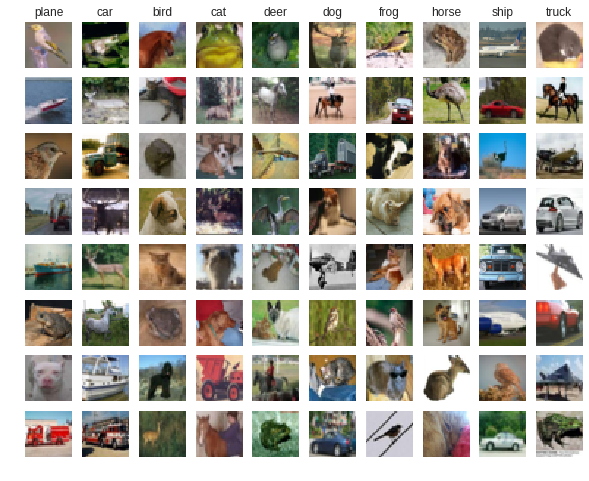

In [17]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [18]:
print (X_train_feats.shape)

(49000, 155)


In [20]:
from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

learning_rates = [1e0,1.3]
regularization_strengths = [1e-3,1e-4]
best_val = -1
results = {}

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=400,
            learning_rate=lr, learning_rate_decay=0.90,
            reg=rs, verbose=True)        
        y_train_pred = net.predict(X_train_feats)
        acc_tr = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_tr, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_net = net
            
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.423825
iteration 200 / 2000: loss 1.468709
iteration 300 / 2000: loss 1.336609
iteration 400 / 2000: loss 1.190091
iteration 500 / 2000: loss 1.145764
iteration 600 / 2000: loss 1.049429
iteration 700 / 2000: loss 1.131163
iteration 800 / 2000: loss 1.116212
iteration 900 / 2000: loss 1.024253
iteration 1000 / 2000: loss 1.042238
iteration 1100 / 2000: loss 0.997359
iteration 1200 / 2000: loss 0.915052
iteration 1300 / 2000: loss 0.905877
iteration 1400 / 2000: loss 0.881240
iteration 1500 / 2000: loss 0.923746
iteration 1600 / 2000: loss 0.882412
iteration 1700 / 2000: loss 0.941211
iteration 1800 / 2000: loss 0.931063
iteration 1900 / 2000: loss 0.891984
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.319158
iteration 200 / 2000: loss 1.255188
iteration 300 / 2000: loss 1.155721
iteration 400 / 2000: loss 1.095104
iteration 500 / 2000: loss 1.045574
iteration 600 / 2000: loss 1.098639
iteration 700 / 2000: 

iteration 1300 / 2000: loss 0.664837
iteration 1400 / 2000: loss 0.609557
iteration 1500 / 2000: loss 0.668562
iteration 1600 / 2000: loss 0.613358
iteration 1700 / 2000: loss 0.569878
iteration 1800 / 2000: loss 0.518458
iteration 1900 / 2000: loss 0.458157
lr 1.000000e+00 reg 1.000000e-04 train accuracy: 0.842163 val accuracy: 0.586000
lr 1.000000e+00 reg 1.000000e-03 train accuracy: 0.786082 val accuracy: 0.603000
lr 1.300000e+00 reg 1.000000e-04 train accuracy: 0.870245 val accuracy: 0.577000
lr 1.300000e+00 reg 1.000000e-03 train accuracy: 0.809469 val accuracy: 0.593000
best validation accuracy achieved during cross-validation: 0.603000


In [0]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print (test_acc)

0.594


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!